# prep

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

plt.rcParams['pdf.fonttype'] = 42 # export pdf with editable text compatible with coreldraw
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none' # export svg compatible with coreldraw

import scipy.io as sio
import scipy.stats as stats

from tqdm import tqdm
from IPython.display import clear_output
import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter/'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [9]:
dir_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_fig = repo_dir + r'\results\tuning bias'.replace('\\', '/')
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)


meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


# batch write df_tidy (don't rerun unless needed)

In [1059]:
# meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# nset = len(meta)

# for iset in tqdm(range(nset)):
#     print(f'iset={iset}, nset={nset}')


#     ## load data
#     mouse = meta.loc[iset, 'mouse'].astype(str)
#     imouse = 'i' + mouse
#     date = meta.loc[iset, 'date'].astype(str)
#     area = meta.loc[iset, 'area']
#     sess = meta.loc[iset, 'num']
#     print(mouse, date, area, sess)
#     dir_identifier = f'{area}_{imouse}_{date}_{sess}'

#     mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
#     for dirname in os.listdir(mat_inter):
#         if dir_identifier in dirname:
#             dir_data = mat_inter + dirname
#             break

#     stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
#     ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


#     ## construct dfof
#     R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
#     R2_dfof = resp_tg.flatten()
#     dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


#     ## construct cell, trial, resp id
#     ncell = resp_ad.shape[0]
#     ntrial = resp_ad.shape[1]
#     cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
#     cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

#     trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
#     trial_id = np.hstack((trial_id, trial_id))

#     len_df = ncell * ntrial * 2 # 2 for (R1, R2)
#     resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


#     ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
#     trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
#     trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
#     for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
#         trial_stim_orien_dict[item] = i
#     trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

#     trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
#     trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

#     trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
#     trial_isi_nframe = trial_isi_nframe[:ntrial]
#     trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

#     ## make stim info col: same as trial_id - tile then hstack
#     stim_id_col = np.tile(trial_stim_orien_int, ncell)
#     isi_col = np.tile(trial_isi_nframe, ncell)
#     ad_con_col = np.tile(trial_adapter_contrast, ncell)

#     stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
#     isi_col = np.hstack((isi_col, isi_col))
#     ad_con_col = np.hstack((ad_con_col, ad_con_col))

#     df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
#                             'isi': isi_col, 'stim1_contrast': ad_con_col, 
#                             'stim2_id': stim_id_col,})
#     df_tidy['area'] = area
#     df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
#     df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
#     df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

#     df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
#     df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


#     ## vis cell filter, well_fit filter, & img driven cell-stim filter
#     df_tidy['filter_cell_vis'] = np.nan
#     df_tidy['filter_cell_vis_pval'] = np.nan # allow continuous filtering on how significant the cell gets visually driven
#     df_tidy['filter_cell_well_fit'] = np.nan
#     df_tidy['filter_cell_stim'] = np.nan

#     with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f: # changed to strict bonferroni
#     # with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni_strict.pickle'), 'rb') as f: # changed to strict bonferroni
#         filter_file = pickle.load(f)
#     filter_cell_stim = filter_file['img_driven']
#     filter_cell_vis = filter_file['vis_driven']
#     filter_cell_vis_pval = np.min(filter_file['p_ttest'], axis=1) # min pval across all stim
        
#     well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
#     well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

#     for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis_pval'] = filter_cell_vis_pval[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
#         for istim in np.arange(filter_cell_stim.shape[1]):
#             df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
#     # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


#     # ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
#     # fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
#     # ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
#     # ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

#     # ori_pref_runs_sorted = well_fit['ori_pref_runs']
#     # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
#     # # for icell in np.arange(10):
#     # #     plt.plot(ori_pref_runs_sorted[icell, :])

#     # percentile_threshold = 0.9
#     # # if area == 'LI':
#     # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
#     # nrun = ori_pref_runs_sorted.shape[1]
#     # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
#     # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
#     # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


#     # ## goodness of fit (R square) in isi 250 or 750
#     # fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
#     # R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
#     # R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
#     # R_square_250 = R_square[:, 2]
#     # well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
#     # well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


#     # ## write cell property to df_tidy
#     # ncell = df_tidy.cell_id.unique().shape[0]
#     # for icell in np.arange(ncell):
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot. ori_pref_noad1 is same as ori_pref_noad
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0] # take from another run

#     #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
#     #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
#     # break

#     ## save df_tidy as csv
#     df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_continuous_vis_pval.csv'), index=False)

# # clear_output()

  0%|          | 0/46 [00:00<?, ?it/s]

iset=0, nset=46
1323 200720 V1 003
ncell: 103, nstim: 8, ntrial: 463


  2%|▏         | 1/46 [00:04<03:36,  4.82s/it]

iset=1, nset=46
1324 200728 V1 003
ncell: 93, nstim: 8, ntrial: 463


  4%|▍         | 2/46 [00:16<06:26,  8.79s/it]

iset=2, nset=46
1322 200803 V1 002
ncell: 97, nstim: 8, ntrial: 463


  7%|▋         | 3/46 [00:31<08:20, 11.64s/it]

iset=3, nset=46
1328 201015 V1 004
ncell: 82, nstim: 8, ntrial: 464


  9%|▊         | 4/46 [00:45<08:44, 12.48s/it]

iset=4, nset=46
1329 201209 V1 002
ncell: 146, nstim: 8, ntrial: 463


 11%|█         | 5/46 [01:01<09:28, 13.86s/it]

iset=5, nset=46
1337 210120 V1 003
ncell: 62, nstim: 8, ntrial: 464


 13%|█▎        | 6/46 [01:13<08:42, 13.06s/it]

iset=6, nset=46
1323 200721 LM 002
ncell: 39, nstim: 8, ntrial: 465


 15%|█▌        | 7/46 [01:17<06:44, 10.36s/it]

iset=7, nset=46
1324 200729 LM 003
ncell: 52, nstim: 8, ntrial: 464


 17%|█▋        | 8/46 [01:25<05:56,  9.39s/it]

iset=8, nset=46
1322 200804 LM 003
ncell: 69, nstim: 8, ntrial: 464


 20%|█▉        | 9/46 [01:38<06:38, 10.77s/it]

iset=9, nset=46
1328 201119 LM 003
ncell: 71, nstim: 8, ntrial: 464


 22%|██▏       | 10/46 [01:49<06:24, 10.67s/it]

iset=10, nset=46
1328 201127 LM 002
ncell: 40, nstim: 8, ntrial: 463


 24%|██▍       | 11/46 [01:55<05:24,  9.26s/it]

iset=11, nset=46
1329 201217 LM 002
ncell: 107, nstim: 8, ntrial: 464


 26%|██▌       | 12/46 [02:07<05:48, 10.26s/it]

iset=12, nset=46
1329 201217 LM 004
ncell: 90, nstim: 8, ntrial: 463


 28%|██▊       | 13/46 [02:22<06:17, 11.43s/it]

iset=13, nset=46
1337 210127 LM 002
ncell: 86, nstim: 8, ntrial: 464


 30%|███       | 14/46 [02:35<06:20, 11.88s/it]

iset=14, nset=46
1337 210127 LM 003
ncell: 62, nstim: 8, ntrial: 463


 33%|███▎      | 15/46 [02:45<05:57, 11.54s/it]

iset=15, nset=46
1338 210325 LM 002
ncell: 85, nstim: 8, ntrial: 465


 35%|███▍      | 16/46 [02:58<05:55, 11.84s/it]

iset=16, nset=46
1338 210805 LM 002
ncell: 80, nstim: 8, ntrial: 463


 37%|███▋      | 17/46 [03:10<05:44, 11.87s/it]

iset=17, nset=46
1350 211020 LM 002
ncell: 62, nstim: 8, ntrial: 463


 39%|███▉      | 18/46 [03:21<05:28, 11.73s/it]

iset=18, nset=46
1350 211020 LM 003
ncell: 68, nstim: 8, ntrial: 463


 41%|████▏     | 19/46 [03:29<04:44, 10.54s/it]

iset=19, nset=46
1351 220228 LM 002
ncell: 63, nstim: 8, ntrial: 464


 43%|████▎     | 20/46 [03:36<04:07,  9.52s/it]

iset=20, nset=46
1351 220228 LM 003
ncell: 72, nstim: 8, ntrial: 464


 46%|████▌     | 21/46 [03:47<04:05,  9.82s/it]

iset=21, nset=46
1380 230221 LM 002
ncell: 67, nstim: 8, ntrial: 500


 48%|████▊     | 22/46 [03:59<04:16, 10.67s/it]

iset=22, nset=46
1380 230221 LM 003
ncell: 36, nstim: 8, ntrial: 501


 50%|█████     | 23/46 [04:05<03:28,  9.08s/it]

iset=23, nset=46
1373 230302 LM 003
ncell: 139, nstim: 8, ntrial: 502


 52%|█████▏    | 24/46 [04:23<04:19, 11.80s/it]

iset=24, nset=46
1373 230302 LM 004
ncell: 142, nstim: 8, ntrial: 500


 54%|█████▍    | 25/46 [04:44<05:05, 14.56s/it]

iset=25, nset=46
1381 230307 LM 002
ncell: 87, nstim: 8, ntrial: 500


 57%|█████▋    | 26/46 [05:02<05:13, 15.67s/it]

iset=26, nset=46
1381 230307 LM 003
ncell: 98, nstim: 8, ntrial: 500


 59%|█████▊    | 27/46 [05:16<04:47, 15.14s/it]

iset=27, nset=46
1381 230307 LM 004
ncell: 100, nstim: 8, ntrial: 500


 61%|██████    | 28/46 [05:31<04:33, 15.20s/it]

iset=28, nset=46
1323 200723 LI 003
ncell: 33, nstim: 8, ntrial: 464


 63%|██████▎   | 29/46 [05:36<03:23, 11.96s/it]

iset=29, nset=46
1322 200806 LI 003
ncell: 53, nstim: 8, ntrial: 464


 65%|██████▌   | 30/46 [05:42<02:45, 10.35s/it]

iset=30, nset=46
1328 201202 LI 003
ncell: 9, nstim: 8, ntrial: 463


 67%|██████▋   | 31/46 [05:43<01:53,  7.59s/it]

iset=31, nset=46
1328 201202 LI 004
ncell: 29, nstim: 8, ntrial: 463


 70%|██████▉   | 32/46 [05:49<01:38,  7.04s/it]

iset=32, nset=46
1329 210113 LI 004
ncell: 22, nstim: 8, ntrial: 464


 72%|███████▏  | 33/46 [05:56<01:28,  6.83s/it]

iset=33, nset=46
1329 210113 LI 006
ncell: 23, nstim: 8, ntrial: 463


 74%|███████▍  | 34/46 [05:59<01:09,  5.77s/it]

iset=34, nset=46
1337 210203 LI 003
ncell: 43, nstim: 8, ntrial: 463


 76%|███████▌  | 35/46 [06:06<01:06,  6.09s/it]

iset=35, nset=46
1337 210203 LI 004
ncell: 25, nstim: 8, ntrial: 463


 78%|███████▊  | 36/46 [06:10<00:56,  5.61s/it]

iset=36, nset=46
1339 210930 LI 002
ncell: 24, nstim: 8, ntrial: 462


 80%|████████  | 37/46 [06:13<00:42,  4.68s/it]

iset=37, nset=46
1339 210930 LI 003
ncell: 25, nstim: 8, ntrial: 463


 83%|████████▎ | 38/46 [06:18<00:38,  4.81s/it]

iset=38, nset=46
1350 211028 LI 002
ncell: 35, nstim: 8, ntrial: 464


 85%|████████▍ | 39/46 [06:23<00:35,  5.05s/it]

iset=39, nset=46
1350 211028 LI 003
ncell: 34, nstim: 8, ntrial: 462


 87%|████████▋ | 40/46 [06:29<00:31,  5.19s/it]

iset=40, nset=46
1380 230110 LI 002
ncell: 35, nstim: 8, ntrial: 463


 89%|████████▉ | 41/46 [06:33<00:24,  4.89s/it]

iset=41, nset=46
1380 230110 LI 003
ncell: 15, nstim: 8, ntrial: 462


 91%|█████████▏| 42/46 [06:36<00:16,  4.18s/it]

iset=42, nset=46
1373 230228 LI 002
ncell: 73, nstim: 8, ntrial: 501


 93%|█████████▎| 43/46 [06:50<00:21,  7.16s/it]

iset=43, nset=46
1373 230228 LI 003
ncell: 86, nstim: 8, ntrial: 502


 96%|█████████▌| 44/46 [07:04<00:18,  9.43s/it]

iset=44, nset=46
1381 230309 LI 002
ncell: 94, nstim: 8, ntrial: 501


 98%|█████████▊| 45/46 [07:17<00:10, 10.44s/it]

iset=45, nset=46
1381 230309 LI 003
ncell: 33, nstim: 8, ntrial: 478


100%|██████████| 46/46 [07:22<00:00,  9.62s/it]


# batch load df_tidy

In [7]:
meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
df_tidy['date_sess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)
clear_output()

# adaptation by area

## cell level adp & R1 across area

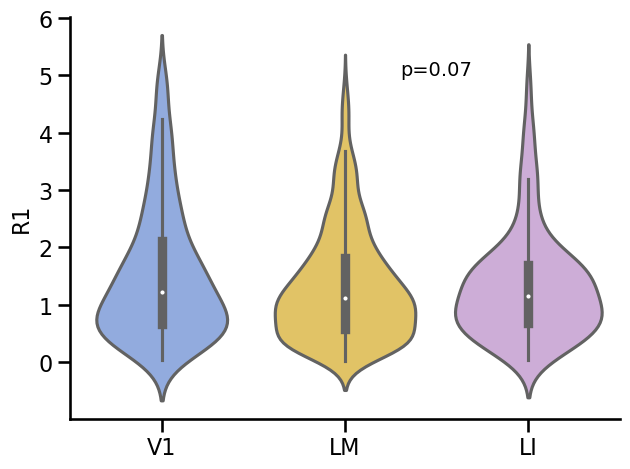

In [8]:
def R1_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)

    gb_R1 = gb_R1[(np.abs(gb_R1 >= 0.01)) 
                & (np.abs(gb_R1 <= 5))
                & (np.abs(gb_adp) < 3) 
                ] # NOTE: use the same cell filter as func adp_in_area

    return gb_R1


df_filter = df_tidy[(df_tidy.filter_cell_vis == True)
                    ]
gb_R1_V1 = R1_in_area(df_filter[df_filter.area == 'V1'])
gb_R1_LM = R1_in_area(df_filter[df_filter.area == 'LM'])
gb_R1_LI = R1_in_area(df_filter[df_filter.area == 'LI'])


ax = sns.violinplot(data=[gb_R1_V1, gb_R1_LM, gb_R1_LI], 
                    palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                    )

_, p_kruskal = stats.kruskal(gb_R1_V1, gb_R1_LM, gb_R1_LI)
plt.text(1.3, 5, 'p={:.2f}'.format(p_kruskal), fontsize=14)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=16);
plt.ylabel('R1', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_R1_by_area_grat8_vis_bonf_corel.svg'))

In [10]:
## kruskal wallis test
print(stats.kruskal(gb_R1_V1, gb_R1_LM, gb_R1_LI))

## mann whitney u test (Wilcoxon rank-sum test)
stats.mannwhitneyu(gb_R1_V1, gb_R1_LM), stats.mannwhitneyu(gb_R1_V1, gb_R1_LI), stats.mannwhitneyu(gb_R1_LM, gb_R1_LI)

KruskalResult(statistic=5.201208368722291, pvalue=0.07422871683356748)


(MannwhitneyuResult(statistic=173663.0, pvalue=0.02376051098395452),
 MannwhitneyuResult(statistic=39041.0, pvalue=0.18682459542909824),
 MannwhitneyuResult(statistic=80582.0, pvalue=0.7403055133138545))

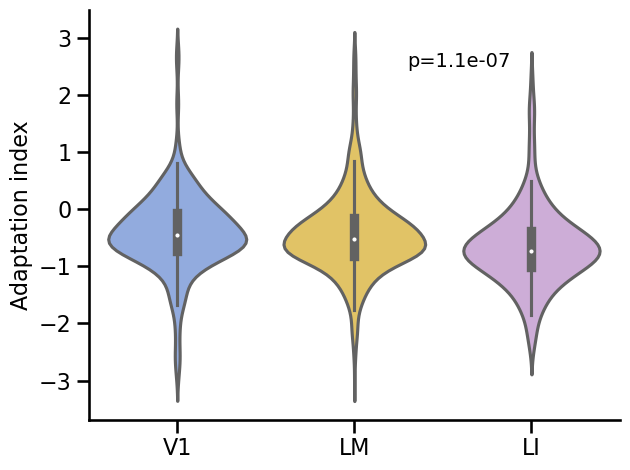

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) ## suppress FutureWarning

def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    
    # gb_adp = gb_adp[np.abs(gb_adp) < 2]
    gb_adp = gb_adp[(np.abs(gb_R1 >= 0.01)) 
                    & (np.abs(gb_R1 <= 5))
                    & (np.abs(gb_adp) < 3) 
                    ]

    return gb_adp


df_filter = df_tidy[(df_tidy.filter_cell_vis == True)
                    ]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])
gb_adp_LI = adp_in_area(df_filter[df_filter.area == 'LI'])


ax = sns.violinplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI], 
                    palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                    )

_, p_kruskal = stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI)
plt.text(1.3, 2.5, 'p={:.1e}'.format(p_kruskal), fontsize=14)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=16);
plt.ylabel('Adaptation index', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_adp_by_area_grat8_vis_bonf_corel_filterR1.svg'))

In [12]:
## kruskal wallis test
print(stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI))

## mann whitney u test (Wilcoxon rank-sum test)
stats.mannwhitneyu(gb_adp_V1, gb_adp_LM), stats.mannwhitneyu(gb_adp_V1, gb_adp_LI), stats.mannwhitneyu(gb_adp_LM, gb_adp_LI)

KruskalResult(statistic=32.064727246017355, pvalue=1.089514329794307e-07)


(MannwhitneyuResult(statistic=172891.0, pvalue=0.03347284244727577),
 MannwhitneyuResult(statistic=46921.0, pvalue=3.087061330014071e-08),
 MannwhitneyuResult(statistic=99331.0, pvalue=3.4548394949551472e-06))

## stacked histogram of vis cell %

In [14]:
df_cell_property = df_tidy.groupby('cell_id').first()
df_cell_property['vis_str'] = 'not visually driven'

nstim = df_tidy.stim2_id.nunique()
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.05 / nstim, 'vis_str'] = 'moderately visually driven' # bonferroni correction
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.01 / nstim, 'vis_str'] = 'strongly visually driven'

df_vis_hist = df_cell_property.groupby('area').vis_str.value_counts().unstack()
df_vis_hist = df_vis_hist.iloc[::-1] # row order: V1, LM, LI
df_vis_hist = df_vis_hist.iloc[:, [1, 0, 2]] # column order: not visually driven -> moderately -> strongly visually driven
df_vis_hist

vis_str,not visually driven,moderately visually driven,strongly visually driven
area,,,
V1,297,99,187
LM,1095,217,403
LI,568,50,73


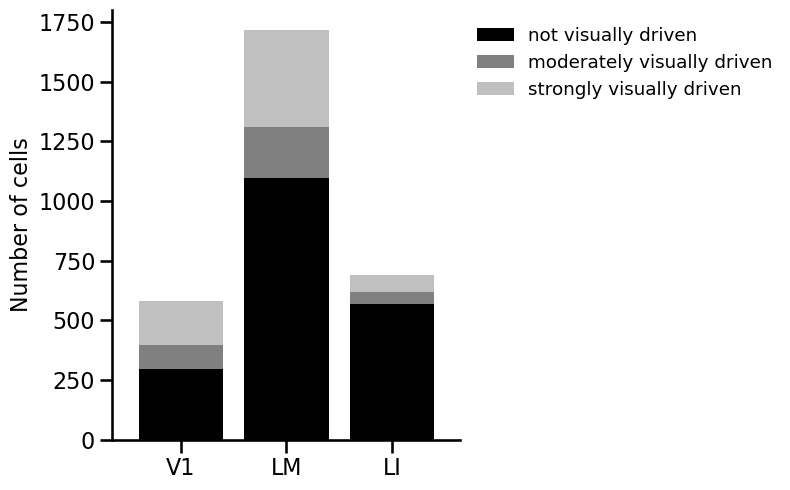

In [16]:
(df_vis_hist
    .plot(kind='bar', stacked=True, 
    figsize=(8, 5), 
    colormap=ListedColormap(["black", "gray", "silver"]), 
    width=0.8) # make bar thinner
    );

plt.legend(frameon=False, bbox_to_anchor=(1, 1));
plt.xticks(rotation=0, fontsize=16); # rotate x tick labels back to horizontal
plt.xlabel('')
plt.ylabel('Number of cells', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'vis_cell_by_area.svg'))

# tuning bias with well-max
take max resp as ori_pref

## filter cell well-max (no rerun)

In [26]:
## construct tuning_vec column

max_ori_bootstrap = np.array([])
nboot = 50

for iboot in tqdm(range(nboot)):
    max_ori = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .sample(frac=.7, random_state=iboot) # sample x trials per group. min rep = 48
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
                .groupby(['cell_id', 'isi']).apply(lambda x: np.argmax(x)) # get ori with max resp
                .reset_index() # NOTE: due to prev groupby, cell_id and isi are in order
                .rename(columns={0: 'max_ori'}).max_ori.values
                )
    max_ori_bootstrap = np.append(max_ori_bootstrap, max_ori)

100%|██████████| 50/50 [03:50<00:00,  4.61s/it]


In [27]:
max_ori_bootstrap = max_ori_bootstrap.reshape(nboot, -1) # reshape max_ori_bootstrap to: nboot x (ncell x nisi)

## sort max_ori_bootstrap in each col (across boots)
max_ori_bootstrap = np.sort(max_ori_bootstrap, axis=0)
# sns.heatmap(max_ori_bootstrap[:, 10:30], cmap='viridis', cbar=True, annot=True);

## count the most freq value in each col (across boots)
max_ori_mode_freq = stats.mode(max_ori_bootstrap, axis=0)[1] # count of mode (freq of most freq max_ori)
filter_cell_well_max = (max_ori_mode_freq >= nboot * 0.7) # NOTE: strictness of well-max can be adjusted here

## merge filter_cell_well_max with df
df_well_max = (df_tidy[df_tidy.resp_id == 'R2'][['cell_id', 'isi']]
                .groupby(['cell_id', 'isi'])
                .first() # get first trial per cell, isi
                .reset_index() # due to prev groupby, cell_id and isi are in the same order as max_ori
                )
df_well_max['filter_cell_well_max'] = filter_cell_well_max
df_well_max

,cell_id,isi,filter_cell_well_max
0,200720_003_0,250,False
1,200720_003_0,750,True
2,200720_003_0,6000,False
3,200720_003_1,250,True
4,200720_003_1,750,False
...,...,...,...
8962,230309_003_8,750,False
8963,230309_003_8,6000,True
8964,230309_003_9,250,True
8965,230309_003_9,750,False


In [28]:
## inherit df_well_max['filter_cell_well_max']
df_tidy = df_tidy.merge(
      df_well_max, 
      on=['cell_id', 'isi'], how='left') # take filter_cell_well_max from df_well_max, for each cell and isi
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_vis_pval,filter_cell_well_fit,filter_cell_stim,mouse,date,sess,date_sess,filter_cell_well_max
0,-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,True
1,0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,False
2,-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,False
3,-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,True
4,0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413843,0.074167,230309_003_32,473,R2,750,1,6,LI,0,False,0.181598,0.0,False,1381,230309,003,230309_003,False
2413844,-0.023736,230309_003_32,474,R2,750,1,0,LI,0,False,0.181598,0.0,False,1381,230309,003,230309_003,False
2413845,0.060245,230309_003_32,475,R2,250,1,1,LI,0,False,0.181598,0.0,False,1381,230309,003,230309_003,True
2413846,0.009333,230309_003_32,476,R2,6000,0,2,LI,0,False,0.181598,0.0,False,1381,230309,003,230309_003,False


## pref-ori as max-ori (no rerun)
crude preference: take max-resp orientation as the preferred orien

In [29]:
pref_ori_noad = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_noad'})
                )

pref_ori_ad_250 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_ad_250'})
                )

pref_ori_ad_750 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 750)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_ad_750'})
                )

df_tidy = (df_tidy.merge(pref_ori_noad, on='cell_id')
            .merge(pref_ori_ad_250, on='cell_id')
            .merge(pref_ori_ad_750, on='cell_id'))
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_well_fit,filter_cell_stim,mouse,date,sess,date_sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750
0,-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,...,1.0,False,1323,200720,003,200720_003,True,4,3,3
1,0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,...,1.0,False,1323,200720,003,200720_003,False,4,3,3
2,-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,...,1.0,False,1323,200720,003,200720_003,False,4,3,3
3,-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,...,1.0,False,1323,200720,003,200720_003,True,4,3,3
4,0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,...,1.0,False,1323,200720,003,200720_003,True,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413843,0.074167,230309_003_32,473,R2,750,1,6,LI,0,False,...,0.0,False,1381,230309,003,230309_003,False,5,0,7
2413844,-0.023736,230309_003_32,474,R2,750,1,0,LI,0,False,...,0.0,False,1381,230309,003,230309_003,False,5,0,7
2413845,0.060245,230309_003_32,475,R2,250,1,1,LI,0,False,...,0.0,False,1381,230309,003,230309_003,True,5,0,7
2413846,0.009333,230309_003_32,476,R2,6000,0,2,LI,0,False,...,0.0,False,1381,230309,003,230309_003,False,5,0,7


In [30]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90

def distace_from_adapter(x):
    # adapter is always 0 deg
    x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['pref_ori_noad'].apply(lambda x: distace_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_250'].apply(lambda x: distace_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_750'].apply(lambda x: distace_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter

df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,sess,date_sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
1535086,0.070788,230302_004_53,353,R2,750,1,3,LM,0,True,...,004,230302_004,True,5,3,3,67.5,90,67.5,0.0
1498362,-0.001468,230302_004_10,50,R2,250,1,7,LM,0,True,...,004,230302_004,False,0,0,7,0.0,0,0.0,0.0
10251,-0.030888,200720_003_13,84,R1,250,1,6,V1,0,True,...,003,200720_003,True,0,0,0,0.0,0,0.0,0.0
26153,-0.020128,200720_003_33,401,R1,250,1,0,V1,0,False,...,003,200720_003,True,7,7,3,22.5,0,22.5,0.0
1794444,0.021428,230307_004_31,149,R2,250,1,3,LM,0,False,...,004,230307_004,True,6,6,7,45.0,45,45.0,0.0


## read csv for well-max

In [31]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'), index=False) # takes 80 sec
df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'))
df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,date,sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
1535086,0.070788,230302_004_53,353,R2,750,1,3,LM,0,True,...,230302,4,True,5,3,3,67.5,90,67.5,0.0
1498362,-0.001468,230302_004_10,50,R2,250,1,7,LM,0,True,...,230302,4,False,0,0,7,0.0,0,0.0,0.0
10251,-0.030888,200720_003_13,84,R1,250,1,6,V1,0,True,...,200720,3,True,0,0,0,0.0,0,0.0,0.0
26153,-0.020128,200720_003_33,401,R1,250,1,0,V1,0,False,...,200720,3,True,7,7,3,22.5,0,22.5,0.0
1794444,0.021428,230307_004_31,149,R2,250,1,3,LM,0,False,...,230307,4,True,6,6,7,45.0,45,45.0,0.0


## ncell by area & well fit %

In [ ]:
tmp = df_tidy.groupby('cell_id').first().reset_index()
tmp[(tmp.filter_cell_vis == True) & (tmp.isi == 250)].groupby(['area']).filter_cell_well_fit.mean()

area
LI    0.136364
LM    0.364238
V1    0.426667
Name: filter_cell_well_fit, dtype: float64

In [ ]:
tmp[(tmp.filter_cell_vis == True) & (tmp.isi == 250)].groupby(['area']).filter_cell_well_max.mean()

area
LI    0.528409
LM    0.543046
V1    0.560000
Name: filter_cell_well_max, dtype: float64

In [42]:
df_cell_property = df_tidy.groupby('cell_id').first()
df_cell_property['filter_cell_well_fit'] = df_cell_property['filter_cell_well_fit'].astype(bool)
# df_cell_property['vis_str'] = 'not visually driven'

# nstim = df_tidy.stim2_id.nunique()
# df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.05 / nstim, 'vis_str'] = 'moderately visually driven' # bonferroni correction
# df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.01 / nstim, 'vis_str'] = 'strongly visually driven'

df_vis_hist = df_cell_property.groupby('area')[['filter_cell_well_max', 'filter_cell_well_fit']].value_counts().unstack()
df_vis_hist = df_vis_hist.iloc[::-1] # row order: V1, LM, LI
# df_vis_hist = df_vis_hist.iloc[:, [1, 0, 2]] # column order: not visually driven -> moderately -> strongly visually driven
df_vis_hist

filter_cell_well_fit       False  True 
area filter_cell_well_max              
V1   True                    184    171
     False                   161     67
LM   True                    612    285
     False                   695    123
LI   True                    290     20
     False                   359     22

In [45]:
vals.sum(axis=1), vals.flatten()

(array([92., 77., 39.]), array([60., 32., 37., 40., 29., 10.]))

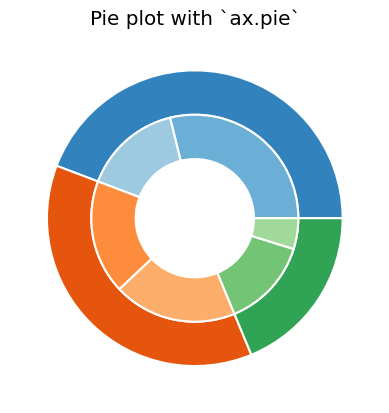

In [43]:
fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

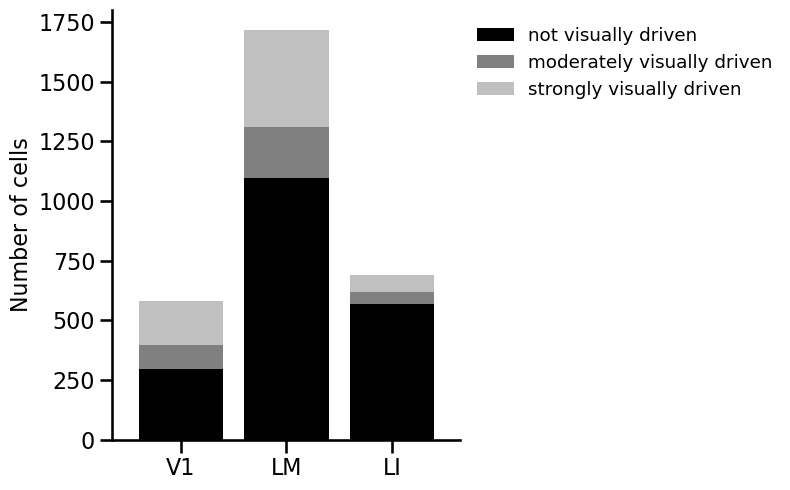

In [ ]:
(df_vis_hist
    .plot(kind='bar', stacked=True, 
    figsize=(8, 5), 
    colormap=ListedColormap(["black", "gray", "silver"]), 
    width=0.8) # make bar thinner
    );

plt.legend(frameon=False, bbox_to_anchor=(1, 1));
plt.xticks(rotation=0, fontsize=16); # rotate x tick labels back to horizontal
plt.xlabel('')
plt.ylabel('Number of cells', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'vis_cell_by_area.svg'))

## tuning bias plot

In [32]:
df_filter = df_tidy[(df_tidy.filter_cell_vis == True) 
                    & (df_tidy.filter_cell_well_max == True)
                    & (df_tidy.isi == 250)
                    ]
df_filter = df_filter.groupby('cell_id').first().reset_index() # drop duplicate cell_id
df_filter.groupby('area').cell_id.nunique()

area
LI    112
LM    532
V1    281
Name: cell_id, dtype: int64

In [ ]:
bias_0_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'V1')].tuning_bias.values
bias_0_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LM')].tuning_bias.values
bias_0_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_0_V1, bias_0_LM, bias_0_LI))

bias_45_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'V1')].tuning_bias.values
bias_45_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LM')].tuning_bias.values
bias_45_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_45_V1, bias_45_LM, bias_45_LI))

bias_90_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'V1')].tuning_bias.values
bias_90_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LM')].tuning_bias.values
bias_90_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_90_V1, bias_90_LM, bias_90_LI))

KruskalResult(statistic=21.597479716168692, pvalue=2.0425225884058178e-05)
KruskalResult(statistic=5.2026785459656955, pvalue=0.07417417219844605)
KruskalResult(statistic=3.2773047556309245, pvalue=0.19424163032056777)


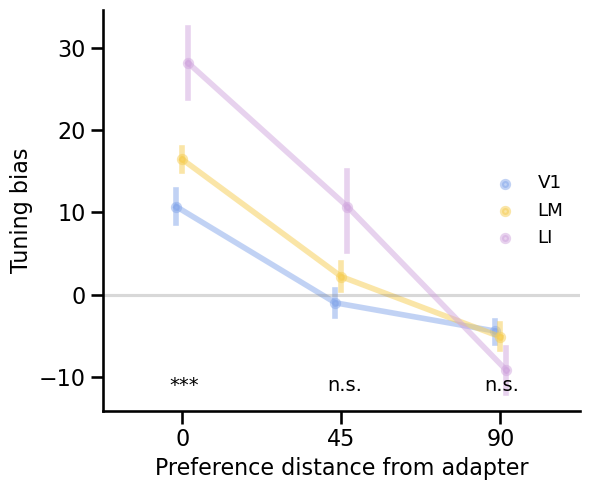

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   dodge=True, markers='.', palette=['#85A7EB', '#F6CD51', '#D1A6DE'],
                   errorbar=('ci', 68), #errwidthfloat=1, capsize=.1,
                   )


y_sig = 0.05
ax.text(0.14, y_sig, '***', transform=ax.transAxes, fontsize=14)
ax.text(0.47, y_sig, 'n.s.', transform=ax.transAxes, fontsize=14)
ax.text(0.8, y_sig, 'n.s.', transform=ax.transAxes, fontsize=14)

plt.setp(ax.collections, alpha=.5);
plt.setp(ax.lines, alpha=.5);
plt.axhline(0, color='gray', linestyle='-', alpha=.3);

plt.legend(frameon=False, loc='right');
plt.xlabel('Preference distance from adapter', fontsize=16);
plt.xticks([0, 1, 2], ['0', '45', '90'], fontsize=16);
plt.ylabel('Tuning bias', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_wellmax_by_area_grat8_vis_bonf_corel.svg'))

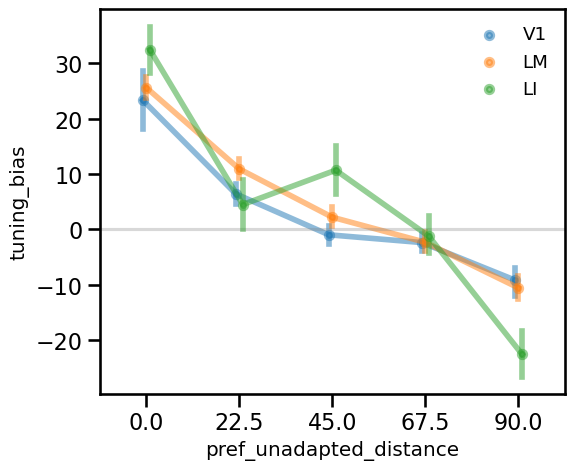

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(x='pref_unadapted_distance', y='tuning_bias', data=df_filter, hue='area',
                   dodge=True, markers='.', 
                   errorbar=('ci', 68), #errwidthfloat=1, capsize=.1,
                   )
plt.setp(ax.collections, alpha=.5);
plt.setp(ax.lines, alpha=.5);
plt.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.legend(frameon=False);

# df for tuning curve

In [146]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'), index=False) # takes 80 sec
df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'))
df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,date,sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
1535086,0.070788,230302_004_53,353,R2,750,1,3,LM,0,True,...,230302,4,True,5,3,3,67.5,90,67.5,0.0
1498362,-0.001468,230302_004_10,50,R2,250,1,7,LM,0,True,...,230302,4,False,0,0,7,0.0,0,0.0,0.0
10251,-0.030888,200720_003_13,84,R1,250,1,6,V1,0,True,...,200720,3,True,0,0,0,0.0,0,0.0,0.0
26153,-0.020128,200720_003_33,401,R1,250,1,0,V1,0,False,...,200720,3,True,7,7,3,22.5,0,22.5,0.0
1794444,0.021428,230307_004_31,149,R2,250,1,3,LM,0,False,...,230307,4,True,6,6,7,45.0,45,45.0,0.0


In [162]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 'filter_cell_well_fit', 
                    # 'filter_cell_well_fit_ad_250', 
                    # 'ori_pref_ad_250', 'ori_pref_noad', 
                    'pref_ori_noad', 'pref_ori_ad_250', 
                    'pref_unadapted_distance', 'pref_unadapted_distance_bin', 'pref_adapted_distance', 
                    'tuning_bias', #'tuning_bias_control',
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    # & (df_tuning.area == 'LI')
                    & (df_tuning.filter_cell_vis == True)
                    & (df_tuning.filter_cell_well_fit == True)
                    # & (df_tuning.filter_cell_well_fit_ad_250 == True) # only use cells that are well fit in both conditions: noad and ad 250
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    # & (df_tuning.pref_unadapted_distance_bin == 90)
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).dfof.agg(np.nanmean).values # groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).dfof.agg(np.nanmean).values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

    # break

100%|██████████| 606/606 [01:20<00:00,  7.51it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,pref_ori_noad,pref_ori_ad_250,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_noad,tuning_250
955231,-0.003812,210325_002_14,R1,250,6,LM,True,1.0,3,0,67.5,90,0.0,-67.5,"[-0.003965219153420706, -0.013117787821717936,...","[0.051384677574545234, 0.016156489006029114, 0..."
955605,0.038286,210325_002_14,R2,250,6,LM,True,1.0,3,0,67.5,90,0.0,-67.5,"[-0.003965219153420706, -0.013117787821717936,...","[0.051384677574545234, 0.016156489006029114, 0..."
955599,-0.018540,210325_002_14,R2,250,0,LM,True,1.0,3,0,67.5,90,0.0,-67.5,"[-0.003965219153420706, -0.013117787821717936,...","[0.051384677574545234, 0.016156489006029114, 0..."
955598,0.062999,210325_002_14,R2,250,3,LM,True,1.0,3,0,67.5,90,0.0,-67.5,"[-0.003965219153420706, -0.013117787821717936,...","[0.051384677574545234, 0.016156489006029114, 0..."
955593,0.063638,210325_002_14,R2,250,1,LM,True,1.0,3,0,67.5,90,0.0,-67.5,"[-0.003965219153420706, -0.013117787821717936,...","[0.051384677574545234, 0.016156489006029114, 0..."


In [163]:
df_tuning.sort_values(by=['tuning_bias'], inplace=True, ascending=False) # df_tuning sort by tuning_bias_distance
# df_tuning.sample(5, random_state=0) # NOTE: where isi=6000, pref_adapted_distance and tuning_bias are NaN
df_tuning.head()

,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,pref_ori_noad,pref_ori_ad_250,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_noad,tuning_250
419611,0.384325,210120_003_12,R1,250,0,V1,True,1.0,1,4,22.5,0,90.0,67.5,"[0.14031719508305063, 0.2306198536906382, 0.00...","[0.036896655813561136, 0.10353710969770374, -0..."
419843,-0.028321,210120_003_12,R2,250,0,V1,True,1.0,1,4,22.5,0,90.0,67.5,"[0.14031719508305063, 0.2306198536906382, 0.00...","[0.036896655813561136, 0.10353710969770374, -0..."
419878,-0.065244,210120_003_12,R2,250,1,V1,True,1.0,1,4,22.5,0,90.0,67.5,"[0.14031719508305063, 0.2306198536906382, 0.00...","[0.036896655813561136, 0.10353710969770374, -0..."
419875,-0.019004,210120_003_12,R2,250,3,V1,True,1.0,1,4,22.5,0,90.0,67.5,"[0.14031719508305063, 0.2306198536906382, 0.00...","[0.036896655813561136, 0.10353710969770374, -0..."
419835,0.162331,210120_003_12,R1,250,5,V1,True,1.0,1,4,22.5,0,90.0,67.5,"[0.14031719508305063, 0.2306198536906382, 0.00...","[0.036896655813561136, 0.10353710969770374, -0..."


## tuning curve across area

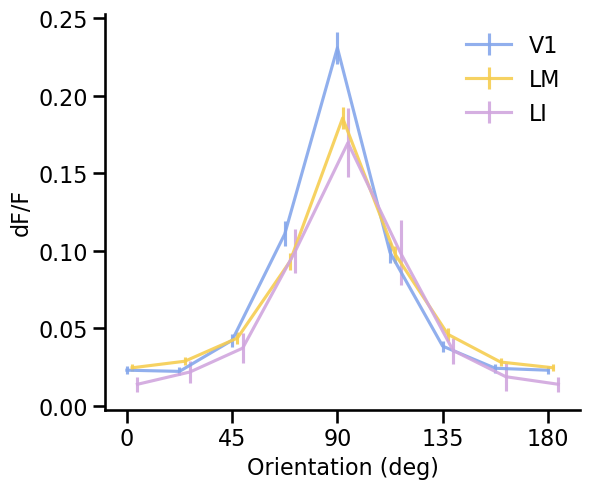

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
color_list = ['#85A7EB', '#F6CD51', '#D1A6DE']

for i, iarea in enumerate(['V1', 'LM', 'LI']):
    tuning_pop = df_tuning[df_tuning.area == iarea].groupby(['cell_id']).tuning_noad.first().values
    nori = len(tuning_pop[0])
    tuning_pop = np.concatenate(tuning_pop).reshape(-1, nori) # reshape array of arrays to 2d array. ncell x nstim (nori)

    ## find pref ori by argmax along ori axis
    pref_ori = np.argmax(tuning_pop, axis=1) # ncell

    ## align tuning curve by pref ori
    tuning_pop_aligned = np.zeros_like(tuning_pop)
    for icell in range(tuning_pop.shape[0]):
        tuning_pop_aligned[icell] = np.roll(tuning_pop[icell], nori//2 - pref_ori[icell]) # shift by nori//2 - pref_ori

    tuning_pop_avg = np.nanmean(tuning_pop_aligned, axis=0) # average across cells
    tuning_pop_avg = np.append(tuning_pop_avg, tuning_pop_avg[0]) # append first element to the end, so it's a circle
    tuning_pop_sem = np.nanstd(tuning_pop_aligned, axis=0) / np.sqrt(tuning_pop.shape[0]) # sem across cells
    tuning_pop_sem = np.append(tuning_pop_sem, tuning_pop_sem[0])

    ax.errorbar(np.arange(len(tuning_pop_avg)) + i*0.1, 
                tuning_pop_avg, 
                yerr=tuning_pop_sem, 
                label=iarea, alpha=.9, 
                color=color_list[i],)

ax.set_ylabel('dF/F', fontsize=16)
ax.set_xlabel('Orientation (deg)', fontsize=16)
xlabels = [str(int(t)) for t in np.arange(0, 180 + 180/nori*2, 180/nori*2)]
ax.set_xticks(np.arange(0, len(tuning_pop_avg), 2), xlabels);
ax.legend(frameon=False, loc='upper right', fontsize=16);
sns.despine();
plt.tight_layout();

# fig.savefig(os.path.join(dir_fig, 'tuning_curve_by_area.svg'))

## polar plot of tuning
before and after adaptation  
filter cells 

In [187]:
# https://stackoverflow.com/questions/58065055/floor-and-ceil-with-number-of-decimals

def my_ceil(a, decimal=0):
    return np.true_divide(np.ceil(a * 10**decimal), 10**decimal)

def my_floor(a, decimal=0):
    return np.true_divide(np.floor(a * 10**decimal), 10**decimal)

my_ceil(0.123, decimal=2), my_floor(0.123, decimal=2)

(0.13, 0.12)

In [209]:
# color_list = '85a7eb-ced3f2-f6cd51-e4cab4-d1a6de-fa9ce0'
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]

# for icell in ['200803_002_55']:
for icell in tqdm(df_tuning[(df_tuning.area == 'LM') 
                            # & (df_tuning.tuning_bias >= 45)
                            ].cell_id.unique()[10:20]):

    icell_area = df_tuning[df_tuning.cell_id == icell].area.values[0]
    if icell_area == 'V1':
        color_unadapted = color_list[0]
        color_adapted = color_list[1]
    elif icell_area == 'LM':
        color_unadapted = color_list[2]
        color_adapted = color_list[3]
    elif icell_area == 'LI':
        color_unadapted = color_list[4]
        color_adapted = color_list[5]

    # gOSI_noad = df_tuning[df_tuning.cell_id == icell].gOSI_noad.values[0]
    # gOSI_250 = df_tuning[df_tuning.cell_id == icell].gOSI_250.values[0]

    tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
    tuning_noad = np.append(tuning_noad, tuning_noad) # repeat 8 values twice to make 16 values for polar plot
    tuning_noad = np.append(tuning_noad, tuning_noad[0]) # repeat first value at the end to close the circle

    # ori_pref_noad = df_tuning[df_tuning.cell_id == icell].ori_pref_noad.values[0]
    ori_pref_noad = df_tuning[df_tuning.cell_id == icell].pref_ori_noad.values[0]
    # print('ori_pref_noad deg: ', np.round(ori_pref_noad, 2))
    ori_pref_noad = ori_pref_noad * np.pi / 180 # degree to radian

    tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
    tuning_250 = np.append(tuning_250, tuning_250)
    tuning_250 = np.append(tuning_250, tuning_250[0])
    # ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].ori_pref_ad_250.values[0]
    ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].pref_ori_ad_250.values[0]
    # print('ori_pref_ad_250 deg: ', np.round(ori_pref_ad_250, 2))
    ori_pref_ad_250 = ori_pref_ad_250 * np.pi / 180

    tuning_bias = df_tuning[df_tuning.cell_id == icell].tuning_bias.values[0]
    # print('no adapter: ', np.round(tuning_noad, 2))
    # print('250 ms: ', np.round(tuning_250, 2))
    # print('tuning_bias: ', np.round(tuning_bias, 2))


    fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection='polar'))
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_noad, 
            alpha=.7, linewidth=10, label='unadapted', color=color_unadapted)
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_250, 
            alpha=.7, linewidth=10, label='adapted', color=color_adapted)

    # plot adapter ori as a line
    min_val = np.min([np.min(tuning_noad), np.min(tuning_250)])
    max_val = np.max([np.max(tuning_noad), np.max(tuning_250)])
    # ax.plot([0, np.pi], [max_val, max_val], color='gray', linewidth=5, alpha=.5, label='adapter ori')

    # ## plot 90 deg as a line
    # ax.plot([np.pi/2, np.pi/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')
    # ax.plot([np.pi*3/2, np.pi*3/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')

    # ## plot pref ori (noad) as a line
    # ax.plot([ori_pref_noad, ori_pref_noad], [min_val, max_val], color='blue', linewidth=5, alpha=.5, label='pref ori no adapter')
    # ori_pref_noad_opp = ori_pref_noad + np.pi # find opposite orientation of pref ori
    # if ori_pref_noad_opp > 2*np.pi:
    #     ori_pref_noad_opp = ori_pref_noad_opp - 2*np.pi
    # ax.plot([ori_pref_noad_opp, ori_pref_noad_opp], [min_val, max_val], color='blue', linewidth=5, alpha=.5, linestyle='-')

    # ## plot pref ori (ad 250) as a line
    # ax.plot([ori_pref_ad_250, ori_pref_ad_250], [min_val, max_val], color='orange', linewidth=5, alpha=.5, label='pref ori isi=250')
    # ori_pref_ad_250_opp = ori_pref_ad_250 + np.pi
    # if ori_pref_ad_250_opp > 2*np.pi:
    #     ori_pref_ad_250_opp = ori_pref_ad_250_opp - 2*np.pi
    # ax.plot([ori_pref_ad_250_opp, ori_pref_ad_250_opp], [min_val, max_val], color='orange', linewidth=5, alpha=.5, linestyle='-')

    # ## add text at top left
    # bias_color = 'blue'
    # minus_flag = 'pos'
    # if tuning_bias < 0: # attractive bias
    #     bias_color = 'red'
    #     minus_flag = 'neg'
    # plt.text(0.05, 0.9, f'tuning_bias: {np.round(tuning_bias, 2)}', transform=plt.gcf().transFigure, color=bias_color, fontsize=16) # in cartesian coordinates

    # gOSI_color = 'green'
    # if gOSI_noad < 0.5 or gOSI_250 < 0.5:
    #     gOSI_color = 'orange'
    # if gOSI_noad < 0.5 and gOSI_250 < 0.5:
    #     gOSI_color = 'red'
    # plt.text(0.05, 0.85, f'gOSI_noad: {np.round(gOSI_noad, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates
    # plt.text(0.05, 0.8, f'gOSI_250: {np.round(gOSI_250, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates

    rticks = np.arange(0, max_val, step=0.05)
    ax.set_rticks(rticks)  # fewer radial ticks

    ax.set_xticks(np.linspace(0, 2*np.pi, 17))
    ax.tick_params(pad=10) # set tick label distance from axis
    ax.set_xticklabels(np.arange(0, 360+22.5, 22.5))
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    xticklabels[-1] = '' # set final xticklabel invisible
    ax.set_xticklabels(xticklabels)

    yticklabels = np.linspace(my_floor(min_val, 2), my_ceil(max_val, 2), 5)
    ax.set_yticks(yticklabels)
    yticklabels = [np.round(float(label), 2) for label in yticklabels] # round yticklabels to 2 decimal places
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(min_val, max_val)

    area = df_tuning[df_tuning.cell_id == icell].area.values[0]
    ax.set_title(f'cell {icell} in {area}', pad=30, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False); # set legend position out of the way

    # break

    # save figure
    dir_result = r'C:\Users\ll357\Documents\inter\results\tuning bias\polar plot - tuning bias single cell/'.replace('\\', '/')
    # fig.savefig(os.path.join(dir_result, f'gOSI_{np.round(gOSI_noad, 2)}_{icell}_tuning_curve.pdf'), bbox_inches='tight')
    # fig.savefig(os.path.join(dir_result, f'{icell_area}_{icell}_tuning_curve.svg'), bbox_inches='tight')
    plt.close(fig)
    clear_output(wait=True)

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


## filter cell gOSI
for well fit cells, calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [156]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)
df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()#.head(20)

100%|██████████| 636/636 [01:14<00:00,  8.53it/s]


,area,gOSI_noad,gOSI_250
cell_id,,,
200728_003_33,V1,0.866154,0.729479
201015_004_12,V1,0.846736,0.789616
220228_002_16,LM,0.845744,0.809035
201127_002_3,LM,0.843627,0.700373
201015_004_6,V1,0.841990,0.720656
...,...,...,...
201127_002_28,LM,0.173120,0.316416
210805_002_21,LM,0.171098,0.127466
200720_003_65,V1,0.161497,0.068662


In [26]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# df_tuning.sort_values(by='area', ascending=False).groupby(['area', 'cell_id'], sort=False).gOSI_noad.hist(bins=20, alpha=.5, ax=axes[0]);
# df_tuning.sort_values(by='area', ascending=False).groupby(['area', 'cell_id'], sort=False).gOSI_250.hist(bins=20, alpha=.5, ax=axes[1]);

# axes[0].legend(['V1', 'LM', 'LI',], frameon=False) # sorted area descending
# plt.tight_layout();
# ## indeed, gOSI is between 0 and 1. higher gOSI means more orientation selective

In [27]:
df_tuning.groupby('area').gOSI_noad.describe() # df tuning is well-fit cells only. even so, LI gOSI is much worse than V1 and LM

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
LI,15111.0,0.493826,0.105991,0.289015,0.419533,0.491224,0.563361,0.709965
LM,186036.0,0.547436,0.148353,0.114256,0.444634,0.553049,0.661415,0.845744
V1,104642.0,0.547458,0.155385,0.139127,0.426200,0.559070,0.654359,0.866154


In [28]:
df_tidy.groupby('area').filter_cell_well_fit.describe() # well fit cell filter discards most cells in LI already

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
LI,561185.0,0.061358,0.239985,0.0,0.0,0.0,0.0,1.0
LM,1393600.0,0.238967,0.426453,0.0,0.0,0.0,0.0,1.0
V1,459063.0,0.408351,0.491529,0.0,0.0,0.0,1.0,1.0


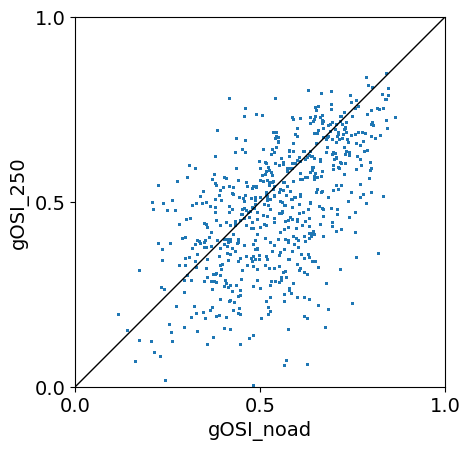

In [29]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

r2 score of gOSI_noad vs tuning_bias:  0.019663151965021997
r2 score of gOSI_250 vs tuning_bias:  0.003738889210329721
slope:  15.16351373942225
intercept:  -6.25223627335961
positive correlation between gOSI and tuning_bias


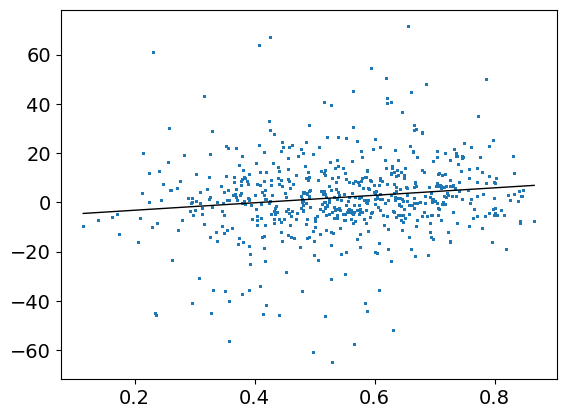

In [30]:
## regression: gOSI vs tuning_bias
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values
tmp1 = tmp1[~np.isnan(tmp3)]
tmp2 = tmp2[~np.isnan(tmp3)]
tmp3 = tmp3[~np.isnan(tmp3)]
tmp1 = tmp1.reshape(-1, 1)
tmp2 = tmp2.reshape(-1, 1)
tmp3 = tmp3.reshape(-1, 1)

reg1 = LinearRegression().fit(tmp1, tmp3)
reg2 = LinearRegression().fit(tmp2, tmp3)
print('r2 score of gOSI_noad vs tuning_bias: ', r2_score(tmp3, reg1.predict(tmp1)))
print('r2 score of gOSI_250 vs tuning_bias: ', r2_score(tmp3, reg2.predict(tmp2)))

plt.scatter(tmp1, tmp3, alpha=.1, s=1);
plt.plot(tmp1, reg1.predict(tmp1), color='k', linestyle='-', linewidth=1);
print('slope: ', reg1.coef_[0][0])
print('intercept: ', reg1.intercept_[0])

print('positive correlation between gOSI and tuning_bias')

### tuning bias plot - high gOSI
didnt seem to help

In [265]:
gOSI_thres = 0.5 # In visual neuroscience, neurons with gOSI > 0.33 are often considered to be orientation-selective (Piscopo et al., 2013; Kondo & Ohki, 2015).
df_tuning_gOSI = df_tuning[(df_tuning.gOSI_noad > gOSI_thres) & (df_tuning.gOSI_250 > gOSI_thres)]
print(df_tuning_gOSI.groupby('area').cell_id.nunique())

df_tuning_gOSI = df_tuning_gOSI.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_tuning_gOSI

area
LI     10
LM    152
V1     94
Name: cell_id, dtype: int64


,cell_id,area,pref_unadapted_distance_bin,tuning_bias,tuning_bias_control
0,200720_003_24,V1,0,11.165754,-4.270538
1,200720_003_29,V1,0,4.465665,6.922370
2,200720_003_57,V1,0,13.236476,0.945789
3,200720_003_59,V1,45,54.626962,7.780432
4,200720_003_61,V1,45,-0.369852,-10.973383
...,...,...,...,...,...
251,230307_004_24,LM,0,28.209884,6.004743
252,230307_004_26,LM,0,-12.258905,3.118108
253,230307_004_45,LM,90,-40.721540,-13.967277
254,230307_004_47,LM,0,7.807087,3.307979


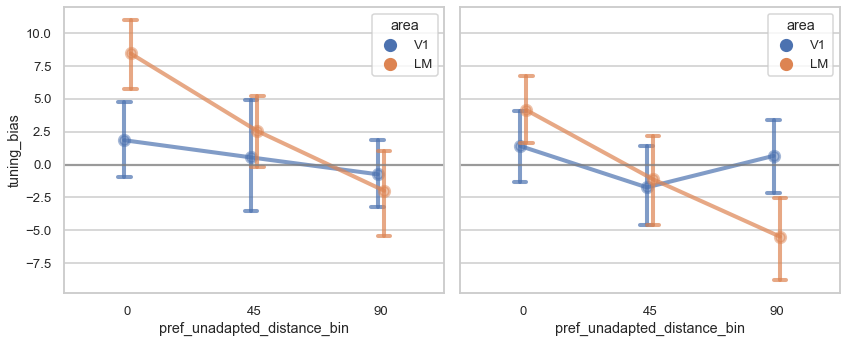

In [266]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_tuning_gOSI[df_tuning_gOSI.area != 'LI'], hue='area',
                   errorbar='sd', # ('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', 
                   data=df_tuning_gOSI[df_tuning_gOSI.area != 'LI'], hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True, legend=False,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

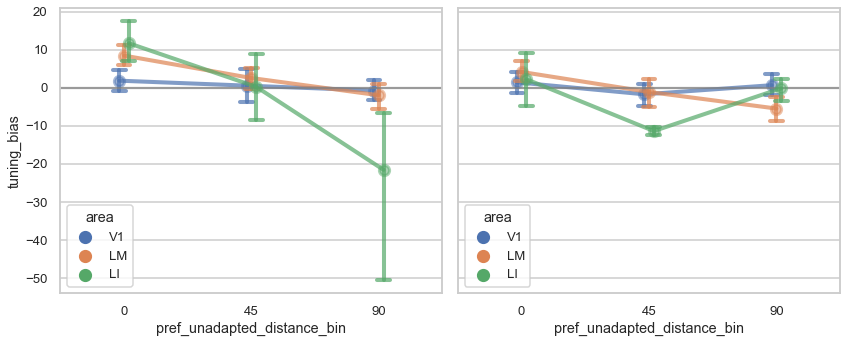

In [267]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_tuning_gOSI, hue='area',
                   errorbar='sd', # ('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', data=df_tuning_gOSI, hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True, legend=False,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

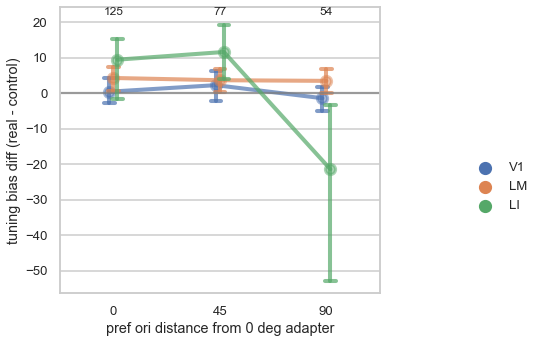

In [268]:
df_tuning_gOSI['tuning_bias_diff'] = df_tuning_gOSI['tuning_bias'] - df_tuning_gOSI['tuning_bias_control']

fig, axes = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_diff', data=df_tuning_gOSI, hue='area',
                   errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                   ax=axes, dodge=True,
                   )

# annotation above each dot, ncell
ncell_bin = df_tuning_gOSI.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 1.5)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_control_diff_by_area.pdf'))

## filter cell ori-mod
dont fit tuning curve, dont filter well fit cells.  
find orientation-modulated cells by anova across all orientations responses

In [31]:
## construct tuning_vec column

cell_property = (df_tidy[['cell_id', 'isi', 'area', 'filter_cell_vis']] # need cell info: area, vis driven
                 .groupby(['cell_id', 'isi']) # prepare to match with df_ori_mod
                 .first() # only take first value. all values should be the same for each cell and isi combination
                 .reset_index())

df_ori_mod = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
              .groupby(['cell_id', 'isi', 'stim2_id']).agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
              .groupby(['cell_id', 'isi']).agg({'dfof':lambda x: list(x)}) # each row is a list of aggregated resp across ori
              .reset_index()
              .rename(columns={'dfof': 'tuning_vec'})
              .merge(cell_property, on=['cell_id', 'isi'], how='left') # merge with cell info
            )
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis
0,200720_003_0,250,"[0.016361998006661493, 0.010278129175002568, 0...",V1,True
1,200720_003_0,750,"[0.025038532340778488, 0.027538047461942633, 0...",V1,True
2,200720_003_0,6000,"[0.020152732636819985, -0.0013945580654881541,...",V1,True
3,200720_003_1,250,"[0.036562610558938564, 0.057022308981587506, 0...",V1,False
4,200720_003_1,750,"[0.050733120887446, 0.03534524443593661, 0.035...",V1,False
...,...,...,...,...,...
8962,230309_003_8,750,"[0.010098233103305406, 0.00922235218530763, 0....",LI,False
8963,230309_003_8,6000,"[-0.0007265278837471503, -0.010356049984017944...",LI,False
8964,230309_003_9,250,"[0.002111642689842034, -0.03229428397250415, -...",LI,False
8965,230309_003_9,750,"[-0.020504815243051422, -0.012417518632523836,...",LI,False


In [32]:
## construct ori_mod column

from scipy.stats import kruskal
p_threshold = 0.05

df_kruskal = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'isi', 'stim2_id']]
            .groupby(['cell_id', 'isi', 'stim2_id']) # for each cell, each isi condition, calc responses to each ori
            .agg({'dfof':lambda x: list(x)}) # each row, dfof col contains a list of ori responses across trials
            .reset_index()
            .groupby(['cell_id', 'isi']) # for each cell, each isi condition, calc ori modulation
            .apply(lambda x: kruskal(*x.dfof.values).pvalue < p_threshold) # kruskal, where each ori is a group
            .reset_index()
            )
df_kruskal = df_kruskal.rename(columns={0: 'ori_mod'}) # bool col for ori modulation

df_ori_mod = df_ori_mod.merge(df_kruskal, on=['cell_id', 'isi'], how='left')
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis,ori_mod
0,200720_003_0,250,"[0.016361998006661493, 0.010278129175002568, 0...",V1,True,False
1,200720_003_0,750,"[0.025038532340778488, 0.027538047461942633, 0...",V1,True,True
2,200720_003_0,6000,"[0.020152732636819985, -0.0013945580654881541,...",V1,True,True
3,200720_003_1,250,"[0.036562610558938564, 0.057022308981587506, 0...",V1,False,False
4,200720_003_1,750,"[0.050733120887446, 0.03534524443593661, 0.035...",V1,False,False
...,...,...,...,...,...,...
8962,230309_003_8,750,"[0.010098233103305406, 0.00922235218530763, 0....",LI,False,False
8963,230309_003_8,6000,"[-0.0007265278837471503, -0.010356049984017944...",LI,False,False
8964,230309_003_9,250,"[0.002111642689842034, -0.03229428397250415, -...",LI,False,True
8965,230309_003_9,750,"[-0.020504815243051422, -0.012417518632523836,...",LI,False,False


In [33]:
## construct max_ori and max_ori_distance column

df_ori_mod['max_ori'] = df_ori_mod.tuning_vec.apply(lambda x: np.argmax(x)) # NOTE: even though we calculated max_ori for isi 250 and 750, only isi 6000 was actually used below (inherited by df_lineplot)
df_ori_mod['max_ori_dist'] = df_ori_mod.max_ori.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # distance from 0 deg, hard coded for 8 ori. TODO: modify if needed

# df_ori_mod.groupby('max_ori').max_ori_distance.value_counts()
# df_ori_mod.groupby('max_ori_distance').max_ori.value_counts()
df_ori_mod.groupby('max_ori').max_ori_dist.unique()

max_ori
0     [0.0]
1    [22.5]
2    [45.0]
3    [67.5]
4    [90.0]
5    [67.5]
6    [45.0]
7    [22.5]
Name: max_ori_dist, dtype: object

In [34]:
## prepare for lineplot. don't need tuning vec, but need (stim2_id, dfof) observations
df_lineplot = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                      [['dfof', 'cell_id', 
                        'area', 'filter_cell_vis',
                        'resp_id', 'isi', 'stim2_id']]
                        .reset_index(drop=True)
                        )
## inherit ori_mod, max_ori, max_ori_distance from df_ori_mod
df_lineplot = df_lineplot.merge(
      df_ori_mod[df_ori_mod.isi == 6000]
      [['cell_id', 'ori_mod', 'max_ori', 'max_ori_dist']], 
      on=['cell_id'], how='left') # only use isi 6000 (no adapter condition) to determine ori_mod, max_ori and max_ori_dist for each cell

## inherit tuning_vec from df_ori_mod, for each isi
df_lineplot = df_lineplot.merge(
      df_ori_mod
      [['cell_id', 'tuning_vec', 'isi']],
      on=['cell_id', 'isi'], how='left') # take tuning_vec from df_ori_mod, for each cell and isi

df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec
0,0.000877,200720_003_0,V1,True,R2,750,5,True,4,90.0,"[0.025038532340778488, 0.027538047461942633, 0..."
1,-0.055881,200720_003_0,V1,True,R2,250,2,True,4,90.0,"[0.016361998006661493, 0.010278129175002568, 0..."
2,0.037413,200720_003_0,V1,True,R2,250,2,True,4,90.0,"[0.016361998006661493, 0.010278129175002568, 0..."
3,0.512942,200720_003_0,V1,True,R2,750,3,True,4,90.0,"[0.025038532340778488, 0.027538047461942633, 0..."
4,0.046603,200720_003_0,V1,True,R2,6000,2,True,4,90.0,"[0.020152732636819985, -0.0013945580654881541,..."
...,...,...,...,...,...,...,...,...,...,...,...
1420146,0.074167,230309_003_32,LI,False,R2,750,6,False,5,67.5,"[-0.00018231075970984991, -0.01066406876792216..."
1420147,-0.023736,230309_003_32,LI,False,R2,750,0,False,5,67.5,"[-0.00018231075970984991, -0.01066406876792216..."
1420148,0.060245,230309_003_32,LI,False,R2,250,1,False,5,67.5,"[0.027510405271565317, 0.009753824245836214, 0..."
1420149,0.009333,230309_003_32,LI,False,R2,6000,2,False,5,67.5,"[-0.04039721066009392, 0.005847991523749155, 0..."


In [35]:
# for each cell_id, divide tuning_vec of isi 250 by tuning_vec of isi 6000
tmp = df_lineplot.groupby(['cell_id', 'isi']).tuning_vec.first().to_frame()
tmp

## split tuning_vec into 8 columns
tmp = tmp.tuning_vec.apply(pd.Series)
tmp

tmp_noad = (tmp.groupby(level=['cell_id']).transform('last'))
tmp_noad

result = tmp - tmp_noad
result

## merge 8 columns back to tuning_vec
result['tuning_diff']= result.values.tolist()
result

0         1         2         3         4         5  \
cell_id      isi                                                                
200720_003_0 250  -0.003791  0.011673  0.033518 -0.012615 -0.032216 -0.022168   
             750   0.004886  0.028933  0.010938  0.076091  0.014486 -0.035019   
             6000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
200720_003_1 250   0.030914  0.049451  0.023036 -0.031079 -0.050838 -0.000731   
             750   0.045084  0.027774  0.037137  0.029714 -0.001707  0.023756   
...                     ...       ...       ...       ...       ...       ...   
230309_003_8 750   0.010825  0.019578 -0.018142 -0.121883 -0.017589  0.013620   
             6000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
230309_003_9 250   0.006161 -0.012827  0.012561  0.040171  0.047026 -0.037958   
             750  -0.016455  0.007050  0.000591 -0.025480  0.056306  0.007642   
             6000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                          6         7  \
cell_id      isi                        
200720_003_0 250  -0.027436 -0.012193   
             750  -0.034831 -0.028225   
             6000  0.000000  0.000000   
200720_003_1 250  -0.018446 -0.041205   
             750  -0.034462 -0.000538   
...                     ...       ...   
230309_003_8 750   0.001717  0.005170   
             6000  0.000000  0.000000   
230309_003_9 250   0.022852 -0.017974   
             750   0.017519  0.009197   
             6000  0.000000  0.000000   

                                                         tuning_diff  
cell_id      isi                                                      
200720_003_0 250   [-0.003790734630158492, 0.011672687240490722, ...  
             750   [0.004885799703958502, 0.028932605527430787, 0...  
             6000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
200720_003_1 250   [0.030913819139125755, 0.04945062365731872, 0....  
             750   [0.04508432946763319, 0.027773559111667828, 0....  
...                                                              ...  
230309_003_8 750   [0.010824760987052555, 0.019578402169325576, -...  
             6000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
230309_003_9 250   [0.006161116563746717, -0.012827232925645988, ...  
             750   [-0.01645534136914674, 0.007049532414334323, 0...  
             6000           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  

[8967 rows x 9 columns]

(-0.10174320629244175, 1.1575233159863254, 0.19320843091334894)

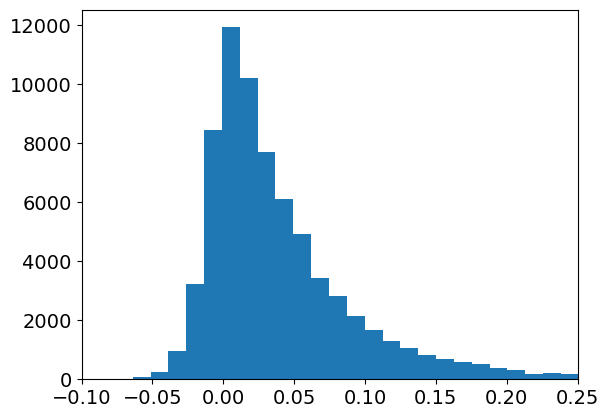

In [36]:
plt.hist(tmp_noad.values.flatten(), bins=100);
plt.xlim([-0.1, 0.25])

np.min(tmp_noad.values.flatten()), np.max(tmp_noad.values.flatten()), \
    sum(tmp_noad.values.flatten() < 0) / len(tmp_noad.values.flatten())

## tuning curve bias
no fitting, just align max response ori

In [37]:
## merge tuning_diff back to df_lineplot
df_lineplot = df_lineplot.merge(
        result.loc[:, 'tuning_diff'].reset_index(), # NOTE tuning_diff is (tuning_ad250 - tuning_noad)
        on=['cell_id', 'isi'], how='left')
df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec,tuning_diff
0,0.000877,200720_003_0,V1,True,R2,750,5,True,4,90.0,"[0.025038532340778488, 0.027538047461942633, 0...","[0.004885799703958502, 0.028932605527430787, 0..."
1,-0.055881,200720_003_0,V1,True,R2,250,2,True,4,90.0,"[0.016361998006661493, 0.010278129175002568, 0...","[-0.003790734630158492, 0.011672687240490722, ..."
2,0.037413,200720_003_0,V1,True,R2,250,2,True,4,90.0,"[0.016361998006661493, 0.010278129175002568, 0...","[-0.003790734630158492, 0.011672687240490722, ..."
3,0.512942,200720_003_0,V1,True,R2,750,3,True,4,90.0,"[0.025038532340778488, 0.027538047461942633, 0...","[0.004885799703958502, 0.028932605527430787, 0..."
4,0.046603,200720_003_0,V1,True,R2,6000,2,True,4,90.0,"[0.020152732636819985, -0.0013945580654881541,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1420146,0.074167,230309_003_32,LI,False,R2,750,6,False,5,67.5,"[-0.00018231075970984991, -0.01066406876792216...","[0.04021489990038407, -0.01651206029167132, -0..."
1420147,-0.023736,230309_003_32,LI,False,R2,750,0,False,5,67.5,"[-0.00018231075970984991, -0.01066406876792216...","[0.04021489990038407, -0.01651206029167132, -0..."
1420148,0.060245,230309_003_32,LI,False,R2,250,1,False,5,67.5,"[0.027510405271565317, 0.009753824245836214, 0...","[0.06790761593165924, 0.003905832722087059, 0...."
1420149,0.009333,230309_003_32,LI,False,R2,6000,2,False,5,67.5,"[-0.04039721066009392, 0.005847991523749155, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [49]:
df_lineplot['date'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[0])
df_lineplot['sess'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[1])
df_lineplot[df_lineplot.area == 'V1'].date.unique()

array(['200720', '200728', '200803', '201015', '201209', '210120'],
      dtype=object)

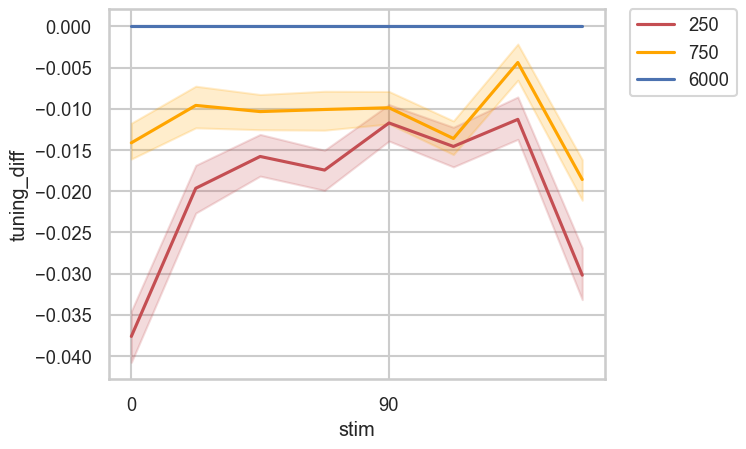

In [54]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                    #    & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'LM')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]
# print(df_filter.groupby('max_ori').cell_id.nunique())
# 
df_tuning_diff = df_filter.groupby(['cell_id', 'isi']).tuning_diff.first().to_frame()
df_tuning_diff = df_tuning_diff.tuning_diff.apply(pd.Series)

# rename columns by adding 'stim' to each column
df_tuning_diff = df_tuning_diff.rename(columns={i: 'stim' + str(i) for i in range(8)})
df_tuning_diff = df_tuning_diff.reset_index()
df_tuning_diff

# pivot table so stim is row
df_tuning_diff = df_tuning_diff.melt(id_vars=['cell_id', 'isi'], var_name='stim', value_name='tuning_diff')
df_tuning_diff

# for stim col, take only the last char
df_tuning_diff['stim'] = df_tuning_diff.stim.apply(lambda x: x[-1])
df_tuning_diff.stim = df_tuning_diff.stim.astype(int)
df_tuning_diff

## set sns color palette
sns.lineplot(data=df_tuning_diff, x='stim', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xticks([0, 4], ['0', '90'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

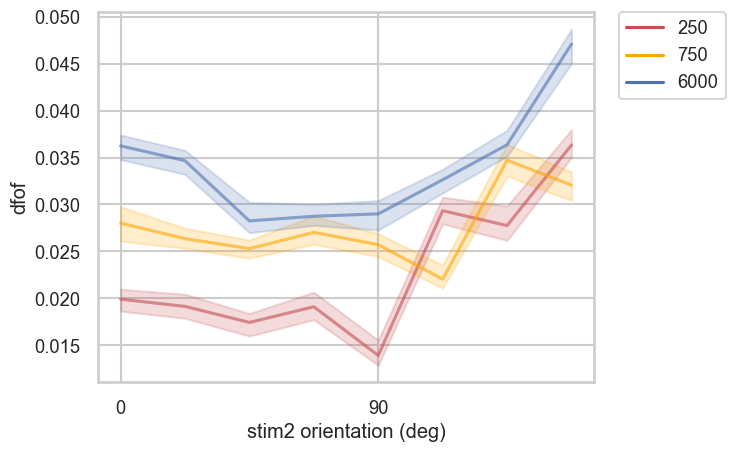

In [55]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, 
            estimator=np.median, 
            palette=['r', 'orange', 'b'],)
plt.xticks([0, 4], ['0', '90'])
plt.xlabel('stim2 orientation (deg)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

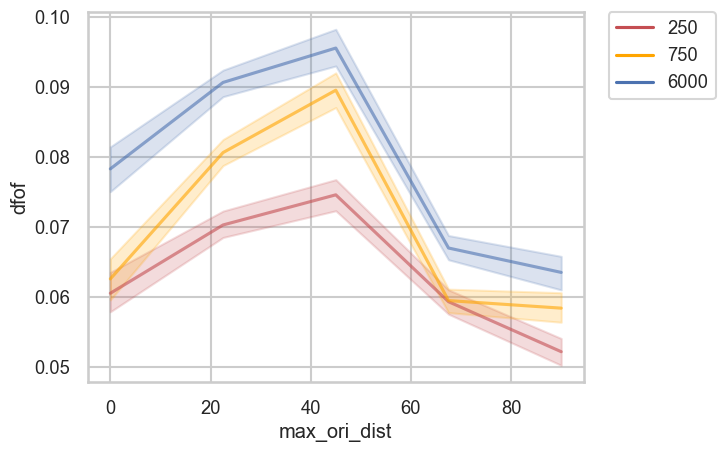

In [56]:
sns.lineplot(data=df_filter, x='max_ori_dist', y='dfof', hue='isi', ci=68, alpha=0.6, 
            estimator=np.mean, 
            palette=['r', 'orange', 'b'],)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

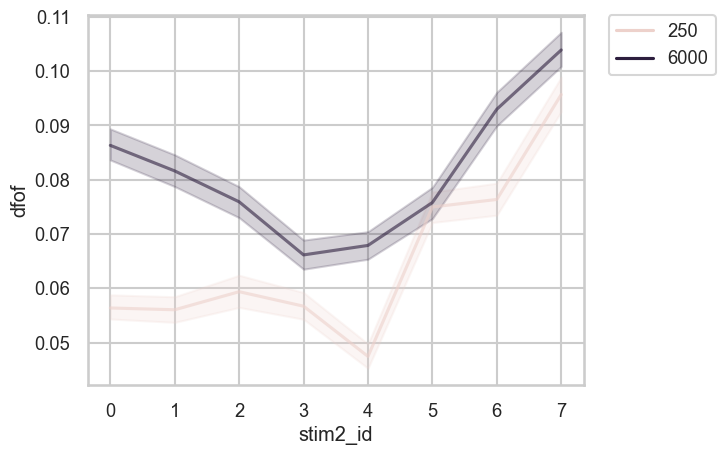

In [47]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'V1')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, 
            # estimator=np.median
            )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, row="date", hue="isi")
# g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
# g.figure.subplots_adjust(wspace=0.1, hspace=0.3)
# g.add_legend();

# # set xticks to 0, 4
# for ax in g.axes.flat:
#     ax.set_xticks([0, 4])
#     ax.set_xticklabels(['0', '90'])


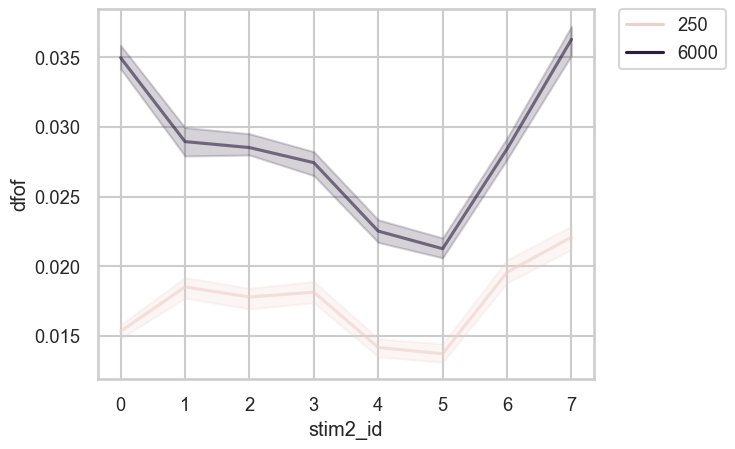

In [394]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'LM')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, estimator=np.median)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

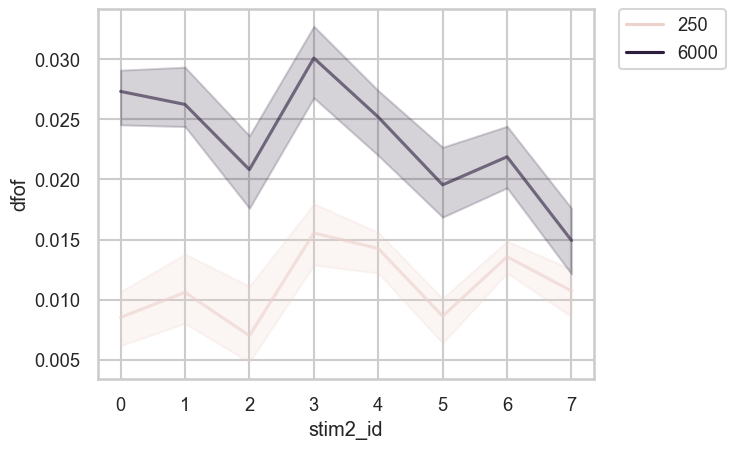

In [395]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'LI')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, estimator=np.median)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Jin 2019 Fig 2

In [66]:
df_lineplot.area.unique()

array(['V1', 'LM', 'LI'], dtype=object)

In [76]:
## construct df for tuning_diff lineplot:
## for each cell_id, subtract tuning_vec of isi 250 by tuning_vec of isi 6000
tmp = df_lineplot.groupby(['cell_id', 'isi']).tuning_vec.first().to_frame()
tmp.head(6)

tmp_noad_shift = tmp.copy()
tmp_noad_shift['tuning_vec'] = tmp_noad_shift.tuning_vec.apply(lambda x: [min(x) for i in range(len(x))])
tmp_noad_shift.head(6)

tmp_noad_shift = (tmp_noad_shift.groupby(level=['cell_id']).transform('last')) # last isi is 6000
epsilon = 0.001
tmp_noad_shift.tuning_vec = tmp_noad_shift.tuning_vec.apply(lambda x: [-min(0, i) + epsilon for i in x])
tmp_noad_shift.head(6)

## split tuning_vec into 8 columns
tmp = tmp.tuning_vec.apply(pd.Series)
tmp.head(6)
# plt.hist(tmp.values.flatten(), bins=100);
# min(tmp.values.flatten()), max(tmp.values.flatten())

tmp_noad_shift = tmp_noad_shift.tuning_vec.apply(pd.Series)
tmp_noad_shift.head(6)

tmp = tmp + tmp_noad_shift # shift tuning_vec of all isi by min(tuning_vec) of isi 6000
tmp.head(6)

tmp_noad = (tmp.groupby(level=['cell_id']).transform('last'))
tmp_noad.head(6)

result = tmp / tmp_noad
result
# plt.hist(result.values.flatten(), bins=100);
# min(result.values.flatten()), max(result.values.flatten())

thresh = 5
result = result.applymap(lambda x: x if abs(x) < thresh else np.nan) # threshold too large values - change to nan
result

## merge 8 columns back to tuning_vec
result['tuning_diff']= result.values.tolist()
result

## merge tuning_diff back to df_lineplot
df_lineplot = df_lineplot.loc[:, df_lineplot.columns != 'tuning_diff'].merge( # prevent duplicate column
        result.loc[:, 'tuning_diff'].reset_index(), # NOTE tuning_diff is (tuning_ad250 - tuning_noad)
        on=['cell_id', 'isi'], how='left')
df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec,date,sess,tuning_diff
0,0.000877,200720_003_0,V1,True,R2,750,5,True,4,90.0,"[0.025038532340778488, 0.027538047461942633, 0...",200720,003,"[1.2166912099757665, nan, 1.4257613946367818, ..."
1,-0.055881,200720_003_0,V1,True,R2,250,2,True,4,90.0,"[0.016361998006661493, 0.010278129175002568, 0...",200720,003,"[0.8318762692951647, nan, 2.3047409011535818, ..."
2,0.037413,200720_003_0,V1,True,R2,250,2,True,4,90.0,"[0.016361998006661493, 0.010278129175002568, 0...",200720,003,"[0.8318762692951647, nan, 2.3047409011535818, ..."
3,0.512942,200720_003_0,V1,True,R2,750,3,True,4,90.0,"[0.025038532340778488, 0.027538047461942633, 0...",200720,003,"[1.2166912099757665, nan, 1.4257613946367818, ..."
4,0.046603,200720_003_0,V1,True,R2,6000,2,True,4,90.0,"[0.020152732636819985, -0.0013945580654881541,...",200720,003,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420146,0.074167,230309_003_32,LI,False,R2,750,6,False,5,67.5,"[-0.00018231075970984991, -0.01066406876792216...",230309,003,"[nan, 0.6505029182133945, -0.9093955642052809,..."
1420147,-0.023736,230309_003_32,LI,False,R2,750,0,False,5,67.5,"[-0.00018231075970984991, -0.01066406876792216...",230309,003,"[nan, 0.6505029182133945, -0.9093955642052809,..."
1420148,0.060245,230309_003_32,LI,False,R2,250,1,False,5,67.5,"[0.027510405271565317, 0.009753824245836214, 0...",230309,003,"[nan, 1.0826715209491216, 1.0962224815562718, ..."
1420149,0.009333,230309_003_32,LI,False,R2,6000,2,False,5,67.5,"[-0.04039721066009392, 0.005847991523749155, 0...",230309,003,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"


In [94]:
df_filter = df_lineplot[(df_lineplot.area == 'V1')
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]
# df_filter

df_tuning_diff = df_filter.groupby(['cell_id', 'isi']).tuning_diff.first().to_frame()
df_tuning_diff = df_tuning_diff.tuning_diff.apply(pd.Series)

# rename columns by adding 'stim' to each column
df_tuning_diff = df_tuning_diff.rename(columns={i: 'stim' + str(i) for i in range(8)})
df_tuning_diff = df_tuning_diff.reset_index()
df_tuning_diff

# pivot table so stim is row
df_tuning_diff = df_tuning_diff.melt(id_vars=['cell_id', 'isi'], var_name='stim', value_name='tuning_diff')
df_tuning_diff

# for stim col, take only the last char
df_tuning_diff['stim'] = df_tuning_diff.stim.apply(lambda x: x[-1])
df_tuning_diff.stim = df_tuning_diff.stim.astype(int)
df_tuning_diff['ori_dist'] = df_tuning_diff.stim.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed. here, we dont align by max ori of cells (to group cells), instead we plot all cells
df_tuning_diff

## inherit max_ori from df_lineplot
df_tuning_diff = df_tuning_diff.merge(df_filter[['cell_id', 'isi', 'max_ori', 'max_ori_dist']], on=['cell_id', 'isi'], how='inner')
df_tuning_diff = df_tuning_diff.drop_duplicates() # TODO: why are there duplicates?
df_tuning_diff

,cell_id,isi,stim,tuning_diff,ori_dist,max_ori,max_ori_dist
0,200720_003_0,250,0,0.831876,0.0,4,90.0
149,200720_003_0,250,1,NaN,22.5,4,90.0
298,200720_003_0,250,2,2.304741,45.0,4,90.0
447,200720_003_0,250,3,0.857256,67.5,4,90.0
596,200720_003_0,250,4,0.638013,90.0,4,90.0
...,...,...,...,...,...,...,...
966835,210120_003_8,6000,3,1.000000,67.5,7,22.5
966972,210120_003_8,6000,4,1.000000,90.0,7,22.5
967109,210120_003_8,6000,5,1.000000,67.5,7,22.5
967246,210120_003_8,6000,6,1.000000,45.0,7,22.5


In [95]:
df_tuning_diff.cell_id.nunique() # how many cells

261

In [96]:
## map with dict
ori_dist_bin = {0:0, 
                22.5:45,
                45:45,
                67.5:90,
                90:90,}

df_tuning_diff['ori_dist_bin'] = df_tuning_diff.ori_dist.map(ori_dist_bin)
df_tuning_diff['max_ori_dist_bin'] = df_tuning_diff.max_ori_dist.map(ori_dist_bin)

df_tuning_diff

,cell_id,isi,stim,tuning_diff,ori_dist,max_ori,max_ori_dist,ori_dist_bin,max_ori_dist_bin
0,200720_003_0,250,0,0.831876,0.0,4,90.0,0,90
149,200720_003_0,250,1,NaN,22.5,4,90.0,45,90
298,200720_003_0,250,2,2.304741,45.0,4,90.0,45,90
447,200720_003_0,250,3,0.857256,67.5,4,90.0,90,90
596,200720_003_0,250,4,0.638013,90.0,4,90.0,90,90
...,...,...,...,...,...,...,...,...,...
966835,210120_003_8,6000,3,1.000000,67.5,7,22.5,90,45
966972,210120_003_8,6000,4,1.000000,90.0,7,22.5,90,45
967109,210120_003_8,6000,5,1.000000,67.5,7,22.5,90,45
967246,210120_003_8,6000,6,1.000000,45.0,7,22.5,45,45


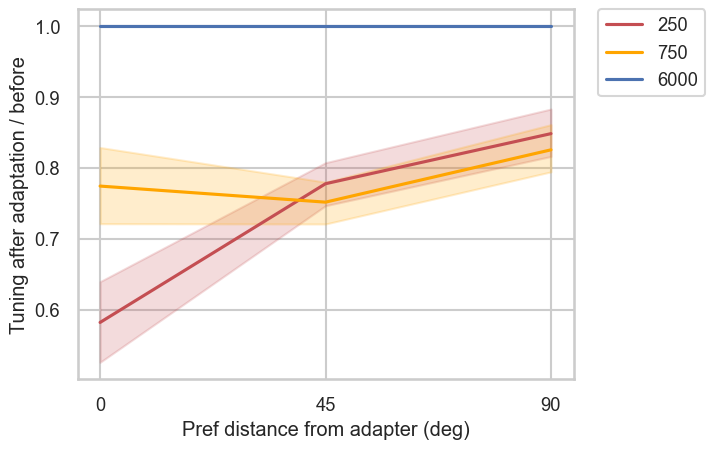

In [97]:
tmp = df_tuning_diff[df_tuning_diff.max_ori == df_tuning_diff.stim] # only take rows with max ori = stim2 ori
tmp

sns.lineplot(data=tmp, x='max_ori_dist_bin', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )

# set xticks 0, 45, 90
plt.xticks([0, 45, 90], [0, 45, 90])

plt.xlabel('Pref distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'Fig2E Jin2019.pdf', bbox_inches='tight')

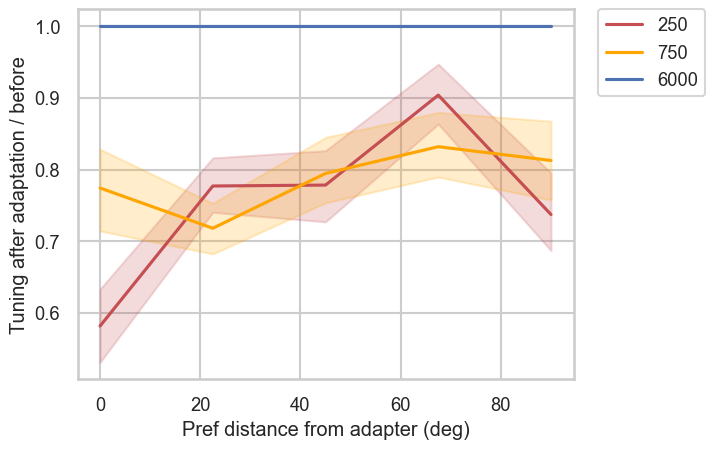

In [98]:
sns.lineplot(data=tmp, x='max_ori_dist', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Pref distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning_diff_lineplot_binned.pdf', bbox_inches='tight')

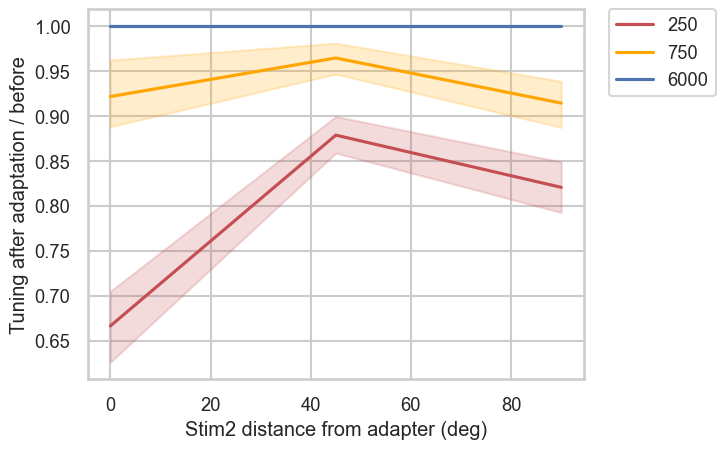

In [89]:
sns.lineplot(data=df_tuning_diff, x='ori_dist_bin', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Stim2 distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning vs stim2_binned-adapter dist.pdf', bbox_inches='tight')

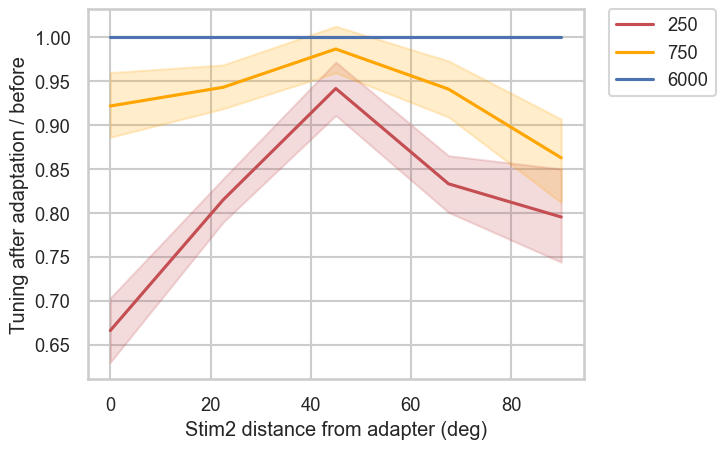

In [90]:
## set sns color palette
sns.lineplot(data=df_tuning_diff, x='ori_dist', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Stim2 distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# # plt.savefig(dir_fig + 'tuning vs stim2-adapter dist.pdf', bbox_inches='tight')
# plt.savefig(dir_fig + 'Fig2D Jin2019.pdf', bbox_inches='tight')

## facet grid

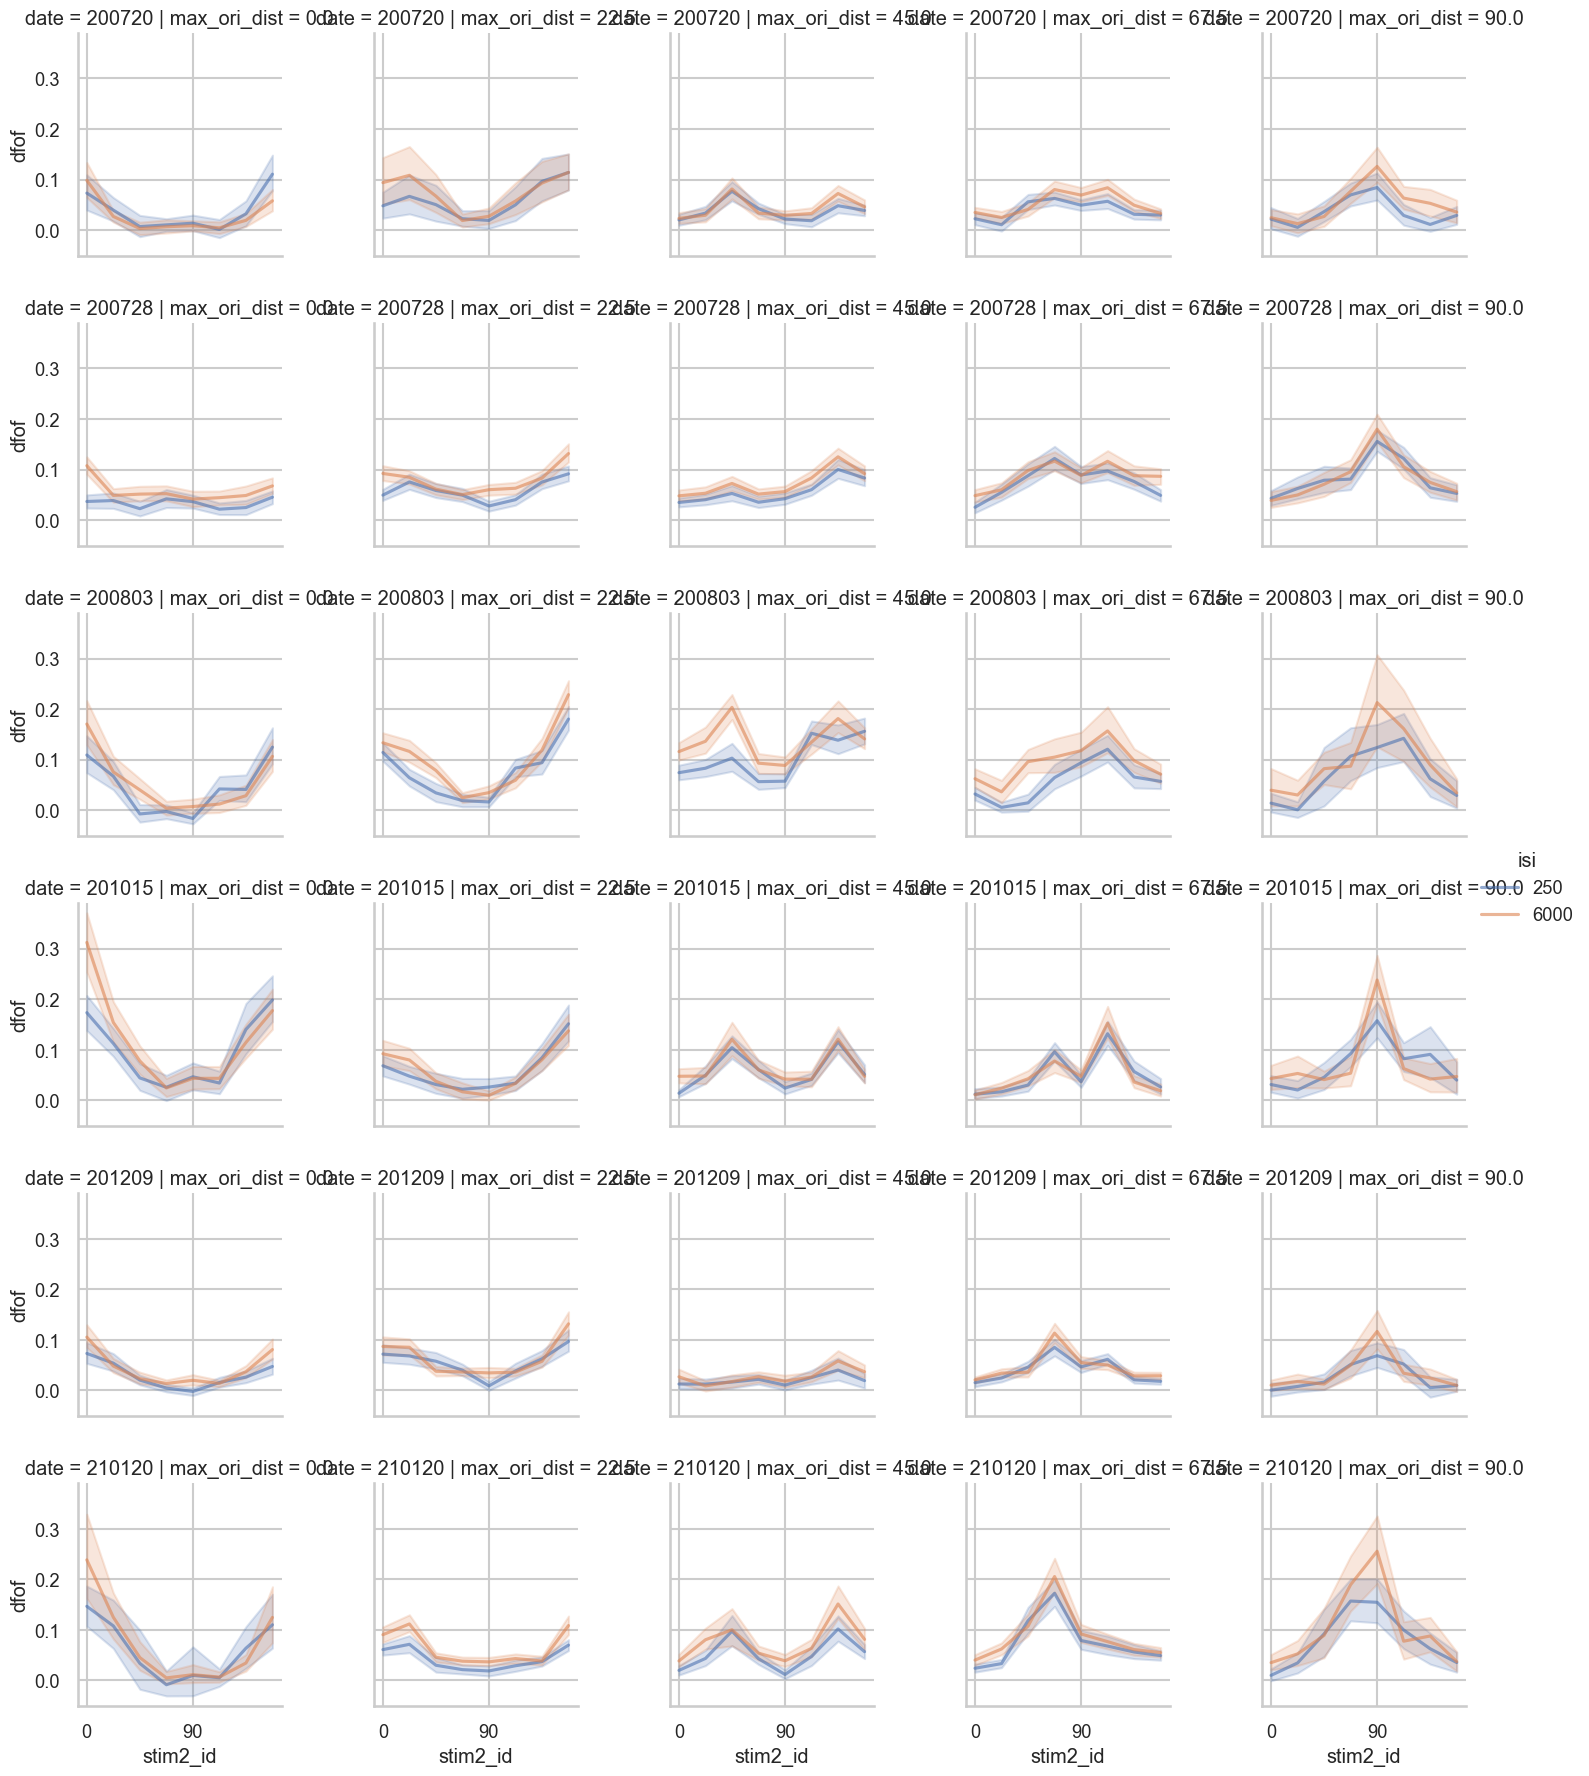

In [378]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                      #  & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.area == 'V1')
                     ##  & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                      #  & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori_dist", hue="isi")
g = sns.FacetGrid(df_filter, col="max_ori_dist", row="date", hue="isi")
# g = sns.FacetGrid(df_filter, col="date", row="max_ori_dist", hue="isi") # which date has the most outrageous adp at orthogonal ori relative to adapter ori
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.45, hspace=0.3)
g.add_legend();

# set xticks to 0, 4
for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])


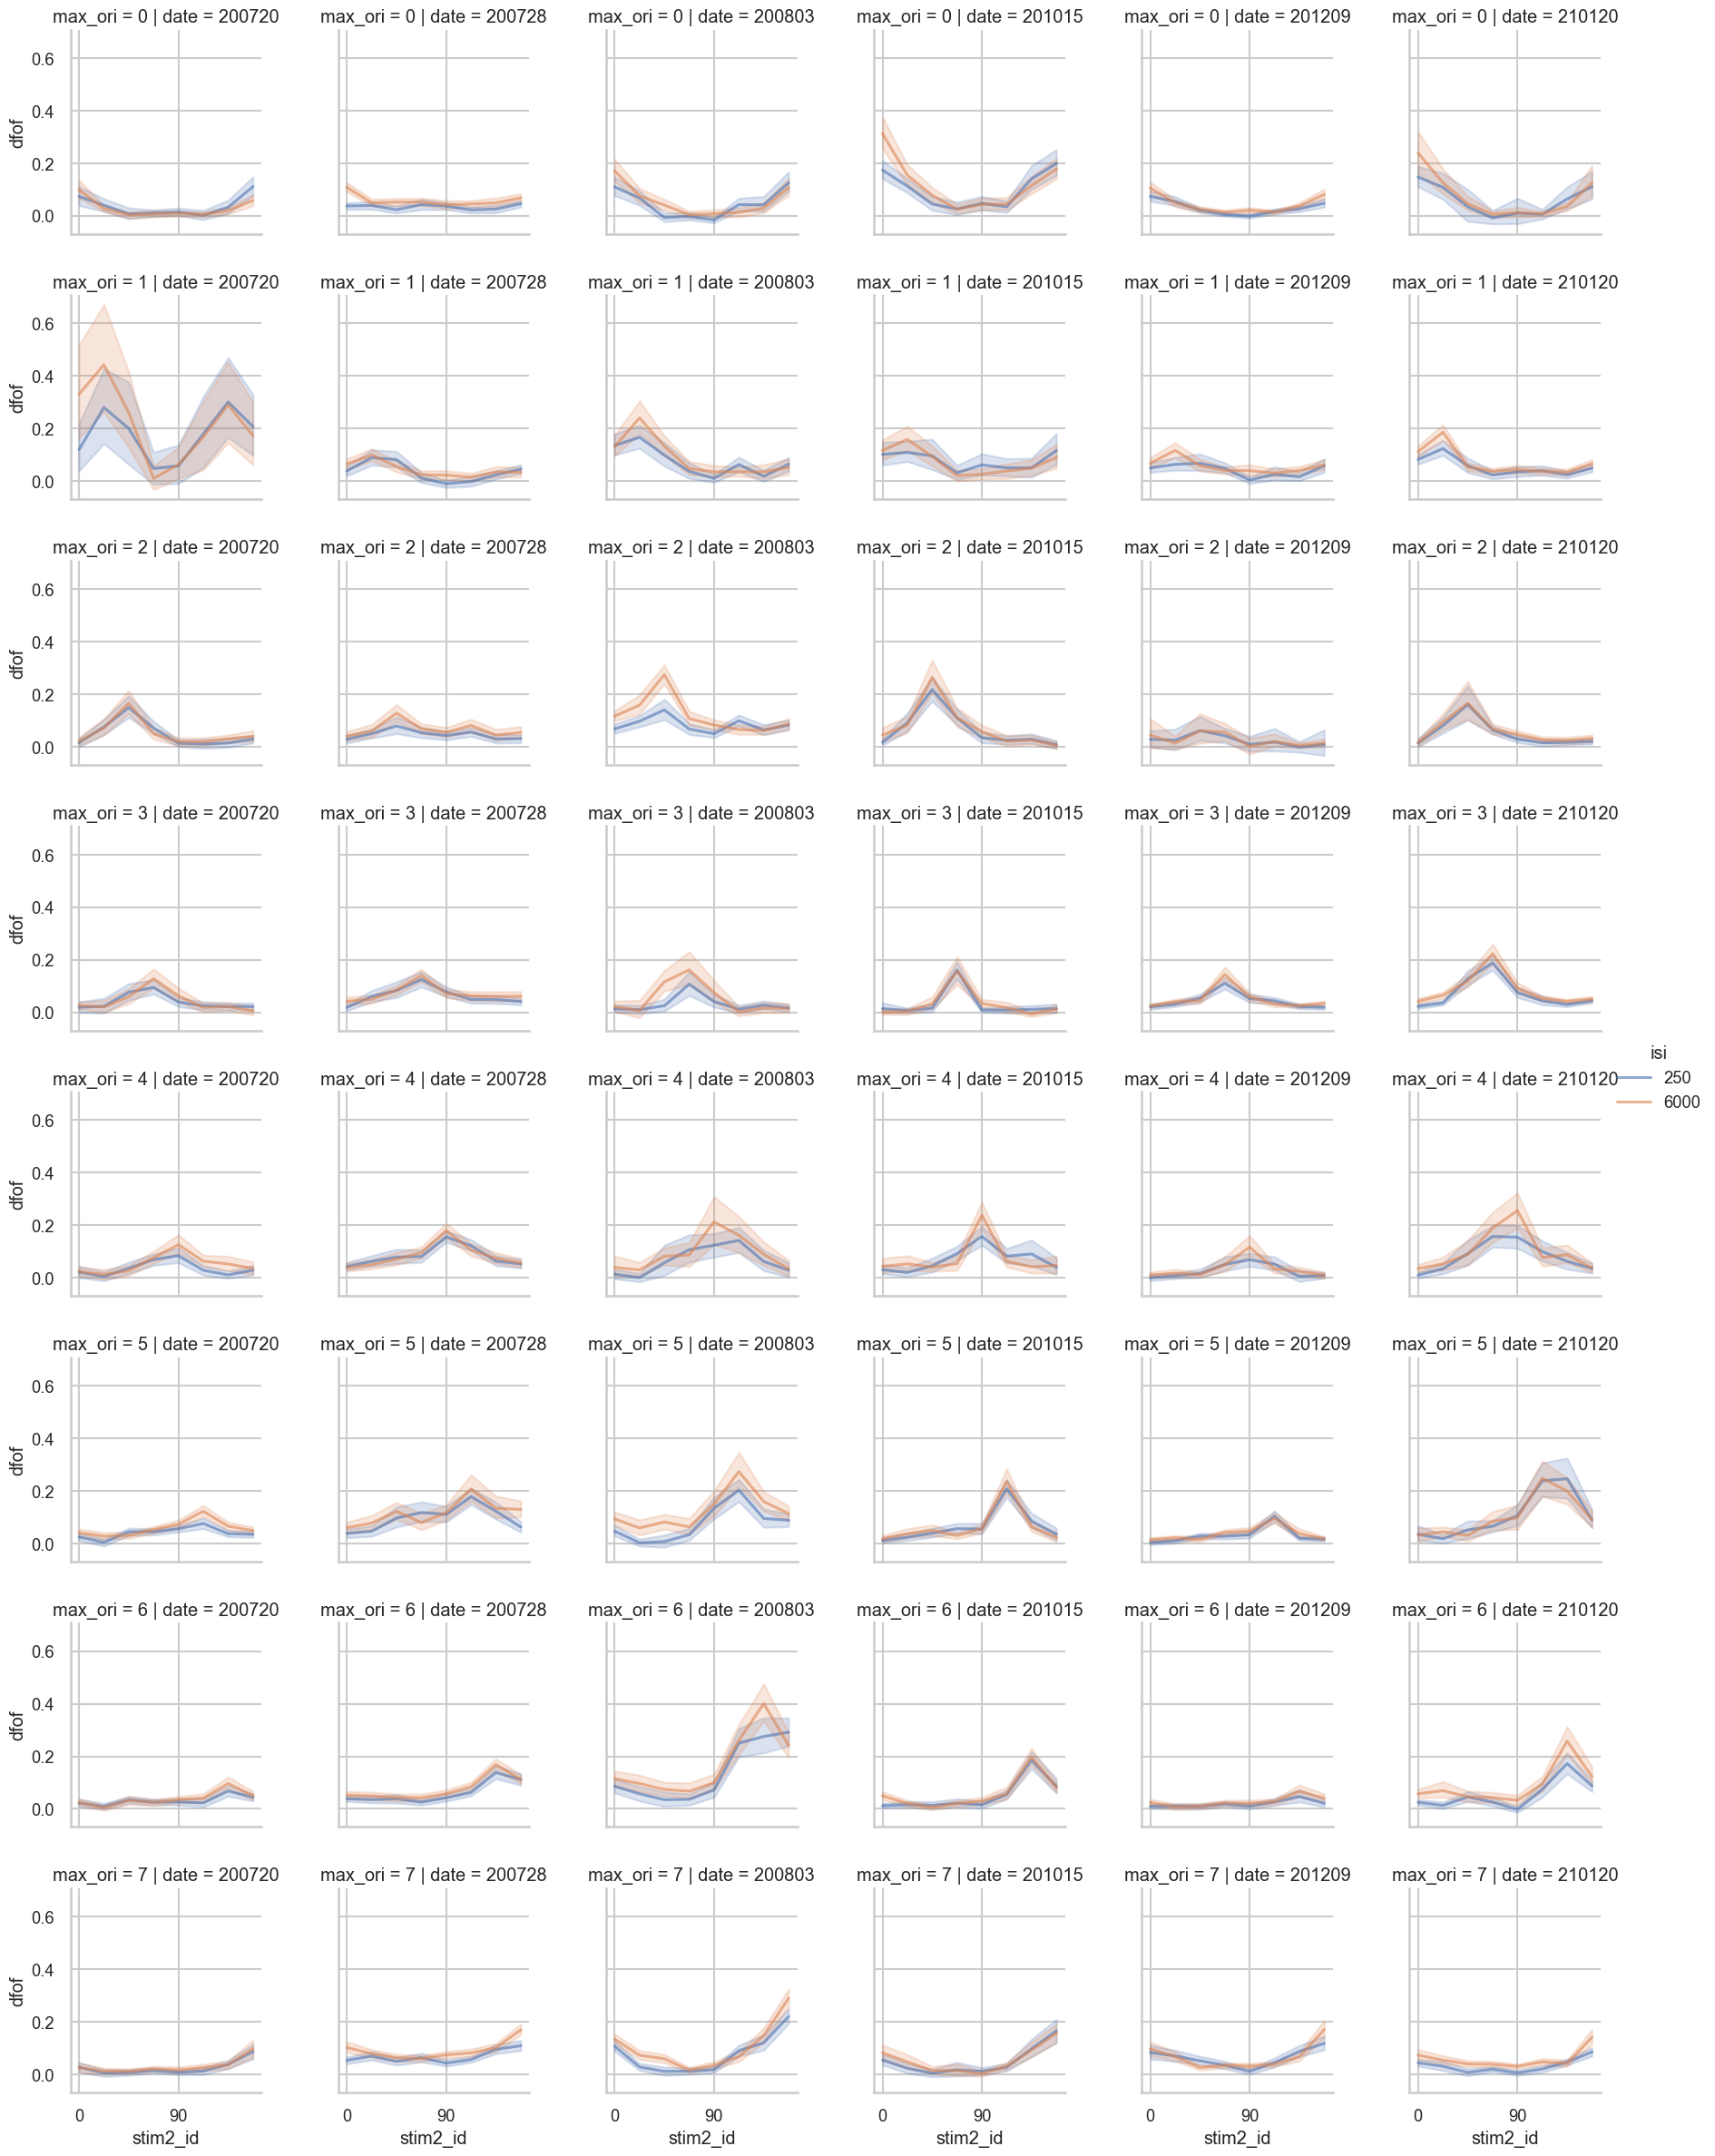

In [379]:
sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori", hue="isi")
g = sns.FacetGrid(df_filter, col="date", row="max_ori", hue="isi")
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])

dir_result = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check'.replace('\\', os.sep)
g.savefig(os.path.join(dir_result, 'tuning_before_vs_after_adp.pdf'), bbox_inches='tight')